In [ ]:
# Inputs required: Soil texture (theta_r, ksat, theta_s), soil moisture (t-12 ... t-1), rainfall (t-12 ... t-1), lat/lon 2d matrices (small), DEM, 
# Gridded rainfall (NOAA AORC), urban (built-up)
# Target: water + flooded vegetation mask from dynamic world

# Target

From https://sentiwiki.copernicus.eu/web/s2-mission The two Sentinel-2 satellites operate simultaneously, phased at 180° to each other, in a sun-synchronous orbit at a mean altitude of 786 km. 

A sun-synchronous orbit (SSO) is designed so that the satellite passes over the same part of the Earth at roughly the same local solar time on each orbit. This means the satellite's overpasses are synchronized with the Sun, ensuring consistent lighting conditions for the same location on Earth over time.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
ds_wfw = xr.open_dataset('dynamic_world_water_flooded_vegetation_2015_2023.nc').chunk({'time': 10000, 'y': 50, 'x': 50})
# Add a new dimension 'z' of size 5
new_coord = np.arange(13)
ds_wfw = ds_wfw.assign_coords(time_window=("time_window", new_coord))
ds_wfw

<xarray.Dataset> Size: 21GB
Dimensions:      (time: 526, x: 2227, y: 2228, time_window: 13)
Coordinates:
  * time         (time) datetime64[ns] 4kB 2015-08-06T17:00:00 ... 2023-12-30...
  * x            (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y            (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref  int64 8B ...
  * time_window  (time_window) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water        (time, y, x) float64 21GB dask.array<chunksize=(526, 50, 50), meta=np.ndarray>

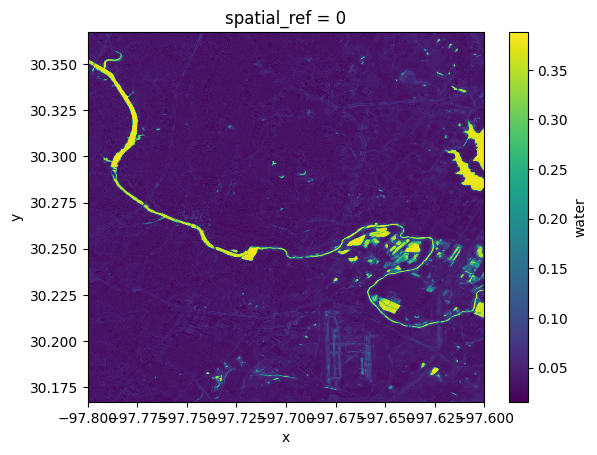

In [19]:
ds_wfw.mean(dim='time').water.plot()

In [2]:
min_wfw = np.nanmin(ds_wfw.water.values)
max_wfw = np.nanmax(ds_wfw.water.values)

print(min_wfw, max_wfw)

0.011262228363193572 0.41595203895121813


In [3]:
pd.to_datetime(ds_wfw.time.values).hour.unique()

Index([17], dtype='int32')

# Input: Soil Properties

In [2]:
ds_ksat = xr.open_dataset('soil_texture_austin_ksat_mean.nc').isel(time=0)
ds_theta_r = xr.open_dataset('soil_texture_austin_theta_r_mean.nc').isel(time=0)
ds_theta_s = xr.open_dataset('soil_texture_austin_theta_s_mean.nc').isel(time=0)

print(ds_ksat, ds_theta_r, ds_theta_s)

<xarray.Dataset> Size: 40MB
Dimensions:      (x: 2227, y: 2228)
Coordinates:
    time         datetime64[ns] 8B 1970-01-01
  * x            (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y            (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref  int64 8B ...
Data variables:
    b1           (y, x) float64 40MB ...
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0 <xarray.Dataset> Size: 40MB
Dimensions:      (x: 2227, y: 2228)
Coordinates:
    time         datetime64[ns] 8B 1970-01-01
  * x            (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y            (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref  int64 8B ...
Data variables:
    b1           (y, x) float64 40MB ...
Attrib

In [3]:
print(ds_theta_r.b1.values.min(), ds_theta_r.b1.values.max())
print(ds_theta_s.b1.values.min(), ds_theta_s.b1.values.max())
print(ds_ksat.b1.values.min(), ds_ksat.b1.values.max())


min_theta_r = ds_theta_r.b1.values.min()
max_theta_r = ds_theta_r.b1.values.max()

min_theta_s = ds_theta_s.b1.values.min()
max_theta_s = ds_theta_s.b1.values.max()

min_ksat = ds_ksat.b1.values.min()
max_ksat = ds_ksat.b1.values.max()

print('***************************')

print(min_theta_r, max_theta_r)
print(min_theta_s, max_theta_s)
print(min_ksat, max_ksat)

0.013253905810415745 0.22099609673023224
0.39643242955207825 0.6264151334762573
-1.5628526210784912 1.482730746269226
***************************
0.013253905810415745 0.22099609673023224
0.39643242955207825 0.6264151334762573
-1.5628526210784912 1.482730746269226


# Input: Rainfall 1 km 1 hrly 

In [4]:
# min, max
ds_pr = xr.open_dataset('noaa_aorc_pr_austin_2015_2024.nc').chunk({'time': 10000, 'latitude': 50, 'longitude': 50})
print(ds_pr.APCP_surface.max().values, ds_pr.APCP_surface.min().values)
min_pr_noaa_aorc = ds_pr.APCP_surface.min().values
max_pr_noaa_aorc = ds_pr.APCP_surface.max().values
print(min_pr_noaa_aorc, max_pr_noaa_aorc)

108.6000016182661 0.0
0.0 108.6000016182661


In [5]:
ds_pr = xr.open_dataset('noaa_aorc_pr_austin_2015_2024.nc').chunk({'time': 10000, 'latitude': 50, 'longitude': 50})

# ds_pr_ = ds_pr.interp(latitude=ds_wfw.y.values[128:256], longitude=ds_wfw.x.values[128:256]).APCP_surface
# ds_pr_.values

# Lets do the interpolation inside the dataset

In [6]:
np.sum(np.isnan(ds_pr.isel(time=0).APCP_surface.values))

0

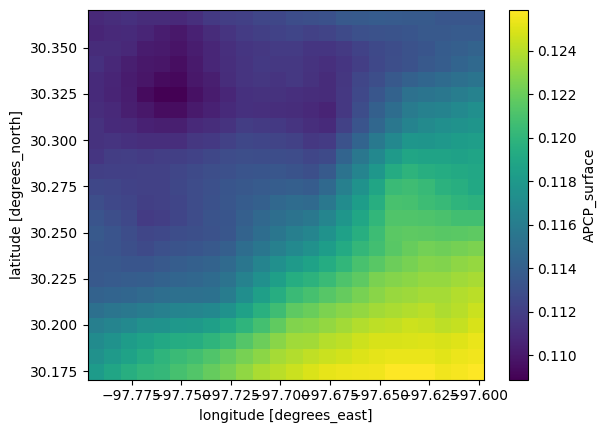

In [17]:
ds_pr.mean(dim='time').APCP_surface.plot()

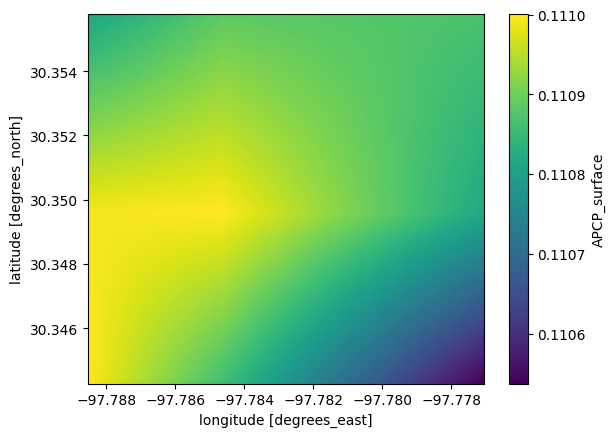

In [21]:
ds_pr_.mean(dim='time').plot()

# Residual wfw

In [7]:
ds_pr.sel(time=ds_wfw.time.values)

<xarray.Dataset> Size: 2MB
Dimensions:       (time: 526, latitude: 24, longitude: 24)
Coordinates:
  * latitude      (latitude) float64 192B 30.17 30.18 30.19 ... 30.36 30.37
  * longitude     (longitude) float64 192B -97.79 -97.78 -97.78 ... -97.61 -97.6
  * time          (time) datetime64[ns] 4kB 2015-08-06T17:00:00 ... 2023-12-3...
Data variables:
    APCP_surface  (time, latitude, longitude) float64 2MB dask.array<chunksize=(11, 24, 24), meta=np.ndarray>

In [8]:
import xarray as xr
import pandas as pd
import numpy as np

generate_data = False

if generate_data:
    # Define the time offset for 12 hours
    time_offset = pd.Timedelta(hours=12)

    # Initialize a NetCDF file to store the data incrementally
    output_file = 'pr_wfw.nc'
    ds_wfw.to_netcdf(output_file, mode='w')  # Write the initial structure of ds_wfw to the file

    # Open the file in append mode using the low-level NetCDF4 library
    import netCDF4 as nc

    # Open the file in append mode
    with nc.Dataset(output_file, 'a') as ds:
        # Create dimensions if they do not exist
        if 'time_window' not in ds.dimensions:
            ds.createDimension('time_window', 13)
        if 'y' not in ds.dimensions:
            ds.createDimension('y', len(ds_wfw.y))
        if 'x' not in ds.dimensions:
            ds.createDimension('x', len(ds_wfw.x))
        
        # Create the variable for pr_wfw
        if 'pr_wfw' not in ds.variables:
            pr_wfw_var = ds.createVariable('pr_wfw', np.float32, ('time', 'time_window', 'y', 'x'))

        # Loop over each time in ds_wfw.time.values
        for i, target_time in enumerate(ds_wfw.time.values):
            # Define the start and end time for the 12-hour window
            start_time = target_time - time_offset
            end_time = target_time

            # Select the data from ds_pr within this time range
            selected_data = ds_pr.sel(time=slice(start_time, end_time))
            selected_data_interp = selected_data.interp(latitude=ds_wfw.y.values, longitude=ds_wfw.x.values)
            selected_data_dask = selected_data_interp.APCP_surface.data.compute()  # Compute to get numpy array

            # Write the selected data to the appropriate slice in the NetCDF file
            ds.variables['pr_wfw'][i, :selected_data_dask.shape[0], :, :] = selected_data_dask

            # Free up memory by deleting intermediate variables
            del selected_data, selected_data_interp, selected_data_dask

    # Verify the result by opening the file
    with xr.open_dataset(output_file) as ds_wfw:
        print(ds_wfw)


In [9]:
pr_wfw = xr.open_dataset('pr_wfw.nc')
pr_wfw

<xarray.Dataset> Size: 178GB
Dimensions:       (time: 526, x: 2227, y: 2228, time_window: 13)
Coordinates:
  * time          (time) datetime64[ns] 4kB 2015-08-06T17:00:00 ... 2023-12-3...
  * x             (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y             (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref   int64 8B ...
  * time_window   (time_window) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water         (time, y, x) float64 21GB ...
    soil_ksat     (y, x) float64 40MB ...
    soil_theta_r  (y, x) float64 40MB ...
    soil_theta_s  (y, x) float64 40MB ...
    dem           (y, x) float64 40MB ...
    built         (time, y, x) float64 21GB ...
    pr_wfw        (time, time_window, y, x) float32 136GB ...

In [10]:
ds_wfw = pr_wfw
ds_wfw

<xarray.Dataset> Size: 178GB
Dimensions:       (time: 526, x: 2227, y: 2228, time_window: 13)
Coordinates:
  * time          (time) datetime64[ns] 4kB 2015-08-06T17:00:00 ... 2023-12-3...
  * x             (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y             (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref   int64 8B ...
  * time_window   (time_window) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water         (time, y, x) float64 21GB ...
    soil_ksat     (y, x) float64 40MB ...
    soil_theta_r  (y, x) float64 40MB ...
    soil_theta_s  (y, x) float64 40MB ...
    dem           (y, x) float64 40MB ...
    built         (time, y, x) float64 21GB ...
    pr_wfw        (time, time_window, y, x) float32 136GB ...

In [11]:
ds_ksat

<xarray.Dataset> Size: 40MB
Dimensions:      (x: 2227, y: 2228)
Coordinates:
    time         datetime64[ns] 8B 1970-01-01
  * x            (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y            (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref  int64 8B ...
Data variables:
    b1           (y, x) float64 40MB 0.3894 0.3894 0.3716 ... -0.9384 -0.9384
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

In [12]:
ds_wfw['soil_ksat'] = (('y', 'x'), ds_ksat.b1.values)
ds_wfw['soil_theta_r'] = (('y', 'x'), ds_theta_r.b1.values)
ds_wfw['soil_theta_s'] = (('y', 'x'), ds_theta_s.b1.values)
ds_wfw

<xarray.Dataset> Size: 178GB
Dimensions:       (time: 526, x: 2227, y: 2228, time_window: 13)
Coordinates:
  * time          (time) datetime64[ns] 4kB 2015-08-06T17:00:00 ... 2023-12-3...
  * x             (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y             (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref   int64 8B ...
  * time_window   (time_window) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water         (time, y, x) float64 21GB ...
    soil_ksat     (y, x) float64 40MB 0.3894 0.3894 0.3716 ... -0.9384 -0.9384
    soil_theta_r  (y, x) float64 40MB 0.05419 0.05419 0.04873 ... 0.1225 0.1225
    soil_theta_s  (y, x) float64 40MB 0.4442 0.4442 0.4335 ... 0.5323 0.5323
    dem           (y, x) float64 40MB ...
    built         (time, y, x) float64 21GB ...
    pr_wfw        (time, time_window, y, x) float32 136GB ...

# Input: DEM

In [13]:
ds_dem = xr.open_dataset('usgs_3dep_10m_dem_austin.nc').isel(time=0)
ds_dem

<xarray.Dataset> Size: 40MB
Dimensions:      (x: 2227, y: 2228)
Coordinates:
    time         datetime64[ns] 8B 1970-01-01
  * x            (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y            (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref  int64 8B ...
Data variables:
    elevation    (y, x) float64 40MB ...
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

In [14]:
min_dem = ds_dem.elevation.values.min()
max_dem = ds_dem.elevation.values.max()
print(min_dem, max_dem)

116.23999786376953 283.3416748046875


In [15]:
ds_wfw['dem'] = (('y', 'x'), ds_dem.elevation.values)
ds_wfw

<xarray.Dataset> Size: 178GB
Dimensions:       (time: 526, x: 2227, y: 2228, time_window: 13)
Coordinates:
  * time          (time) datetime64[ns] 4kB 2015-08-06T17:00:00 ... 2023-12-3...
  * x             (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y             (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref   int64 8B ...
  * time_window   (time_window) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water         (time, y, x) float64 21GB ...
    soil_ksat     (y, x) float64 40MB 0.3894 0.3894 0.3716 ... -0.9384 -0.9384
    soil_theta_r  (y, x) float64 40MB 0.05419 0.05419 0.04873 ... 0.1225 0.1225
    soil_theta_s  (y, x) float64 40MB 0.4442 0.4442 0.4335 ... 0.5323 0.5323
    dem           (y, x) float64 40MB 183.5 183.5 183.2 ... 141.5 141.5 141.6
    built         (time, y, x) float64 21GB ...
    pr_wfw        (time, time_window, y, x) float32 136GB ...

# Input: Station TxSON soil moisture and rainfall transformed to gridded

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('newlatlongdata.csv')
cr200_20_df = df[df['folders'] == 'CR200_20']

target_lat = cr200_20_df.LAT.values[0]
target_lon = cr200_20_df.LON.values[0]

# Define the column names
column_names = [
    'TIMESTAMP', 'RECORD', 'Rain_mm_Tot', 'VWC_1_Avg', 'VWC_2_Avg', 'VWC_3_Avg', 
    'T_1_Avg', 'T_2_Avg', 'T_3_Avg', 'EC_1_Avg', 'EC_2_Avg', 'EC_3_Avg', 'BattV_Min'
]

# Read the CSV file, skipping the first 4 lines
df1 = pd.read_csv('raw_data/CR200_20_Hourly.dat', skiprows=4, names=column_names, low_memory=False)

# Convert the TIMESTAMP column to datetime
df1['TIMESTAMP'] = pd.to_datetime(df1['TIMESTAMP'])

# Set the TIMESTAMP column as the index
df1.set_index('TIMESTAMP', inplace=True)

# Convert the relevant columns to numeric
columns_to_convert = [
    'Rain_mm_Tot', 'VWC_1_Avg', 'VWC_2_Avg', 'VWC_3_Avg', 
    'T_1_Avg', 'T_2_Avg', 'T_3_Avg', 'EC_1_Avg', 'EC_2_Avg', 'EC_3_Avg', 'BattV_Min'
]

df1[columns_to_convert] = df1[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Replace values greater than 1 in VWC columns with NaN
vwc_columns = ['VWC_1_Avg', 'VWC_2_Avg', 'VWC_3_Avg']
df1[vwc_columns] = df1[vwc_columns].mask(df1[vwc_columns] > 1)


df1

RECORD  Rain_mm_Tot  VWC_1_Avg  VWC_2_Avg  VWC_3_Avg  \
TIMESTAMP                                                                   
2014-11-04 13:00:00       0          0.0   0.134969   0.258024   0.366296   
2014-11-04 14:00:00       1          0.0   0.165176   0.314725   0.447094   
2014-11-04 15:00:00       2          0.0   0.165123   0.315308   0.447200   
2014-11-04 16:00:00       3          0.0   0.164619   0.315283   0.447635   
2014-11-04 17:00:00       4          0.0   0.164831   0.315283   0.447651   
...                     ...          ...        ...        ...        ...   
2024-07-31 10:00:00    6189          0.0   0.296000   0.369000   0.510000   
2024-07-31 11:00:00    6190          0.0   0.296000   0.368000   0.509000   
2024-07-31 12:00:00    6191          0.0   0.295000   0.367000   0.509000   
2024-07-31 13:00:00    6192          0.0   0.294000   0.365000   0.508000   
2024-07-31 14:00:00    6193          0.0   0.293000   0.364000   0.508000   

                      T_1_Avg   T_2_Avg   T_3_Avg  EC_1_Avg  EC_2_Avg  \
TIMESTAMP                                                               
2014-11-04 13:00:00  18.50414  18.19493  17.94201  0.065346  0.192662   
2014-11-04 14:00:00  22.55304  22.06998  21.75270  0.080609  0.236510   
2014-11-04 15:00:00  22.46066  22.02336  21.66399  0.080926  0.237551   
2014-11-04 16:00:00  22.38601  21.98068  21.62372  0.081091  0.237467   
2014-11-04 17:00:00  22.35487  21.97866  21.62033  0.081200  0.237860   
...                       ...       ...       ...       ...       ...   
2024-07-31 10:00:00  28.01000  27.90000  27.92000  0.217000  0.341000   
2024-07-31 11:00:00  28.73000  28.21000  27.91000  0.216000  0.333000   
2024-07-31 12:00:00  29.53000  28.68000  27.95000  0.215000  0.324000   
2024-07-31 13:00:00  30.47000  29.27000  28.05000  0.215000  0.318000   
2024-07-31 14:00:00  31.36000  29.90000  28.23000  0.214000  0.311000   

                     EC_3_Avg  BattV_Min  
TIMESTAMP                                 
2014-11-04 13:00:00  0.470776        NaN  
2014-11-04 14:00:00  0.575872        NaN  
2014-11-04 15:00:00  0.577742        NaN  
2014-11-04 16:00:00  0.579636        NaN  
2014-11-04 17:00:00  0.580525        NaN  
...                       ...        ...  
2024-07-31 10:00:00  0.771000      13.41  
2024-07-31 11:00:00  0.770000      13.38  
2024-07-31 12:00:00  0.769000      13.35  
2024-07-31 13:00:00  0.767000      13.35  
2024-07-31 14:00:00  0.770000      13.33  

[84677 rows x 12 columns]

In [17]:
import xarray as xr
import dask.array as da
import numpy as np

time_dim = len(df1.index.values)
y_dim = len(ds_wfw['y'].values)
x_dim = len(ds_wfw['x'].values)

# # Create a Dask array with the desired shape
# new_data = da.zeros((time_dim, y_dim, x_dim), chunks=(100, 100, 100))

# Create a Dask array with the desired shape filled with NaNs
new_data = da.full((time_dim, y_dim, x_dim), np.nan, chunks=(100, 100, 100))


ds_txson = xr.Dataset(
    {
        "sm_txson": (("time", "y", "x"), new_data)
    },
    coords={
        "y": ds_wfw['y'],
        "x": ds_wfw['x'],
        "time": df1.index.values
    }
)

# Extract the latitude and longitude values from the dataset
latitudes = ds_wfw['y'].values
longitudes = ds_wfw['x'].values

# Create 2D arrays of latitudes and longitudes
lat_2d, lon_2d = np.meshgrid(latitudes, longitudes, indexing='ij')

# Calculate the squared distance to the target coordinates
distances = (lat_2d - target_lat)**2 + (lon_2d - target_lon)**2

# Find the index of the minimum distance
min_dist_idx = np.unravel_index(np.argmin(distances), distances.shape)

# Get the nearest latitude and longitude indices
nearest_lat_idx = min_dist_idx[0]
nearest_lon_idx = min_dist_idx[1]

print(f"Nearest latitude index: {nearest_lat_idx}, Nearest longitude index: {nearest_lon_idx}")

# Assign the value to the nearest grid point
ds_txson.sm_txson[:, nearest_lat_idx, nearest_lon_idx] = df1.VWC_1_Avg.values

rain_txson = df1.Rain_mm_Tot.values
print('TxSON rainfall max, min', np.max(rain_txson), np.min(rain_txson))
rain_ = rain_txson / np.max(rain_txson)

ds_txson['pr_txson'] = (("time", "y", "x"), new_data)
ds_txson.pr_txson[:, nearest_lat_idx, nearest_lon_idx] = rain_

ds_filled = ds_txson.copy()
ds_filled['mask'] = ds_filled['sm_txson'].copy()

# Replace all valid values with 1, keep NaNs as they are for the 'temperature' variable
ds_filled['mask'] = ds_filled['mask'].where(ds_filled['mask'].isnull(), 1)
ds_filled['mask'] = ds_filled['mask'].fillna(0)
ds_filled['sm_txson'] = ds_filled['sm_txson'].fillna(0)
ds_filled['pr_txson'] = ds_filled['pr_txson'].fillna(0)

ds_filled

Nearest latitude index: 2044, Nearest longitude index: 0
TxSON rainfall max, min 52.57811 0.0


<xarray.Dataset> Size: 10TB
Dimensions:      (time: 84677, y: 2228, x: 2227)
Coordinates:
  * y            (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref  int64 8B 0
  * x            (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * time         (time) datetime64[ns] 677kB 2014-11-04T13:00:00 ... 2024-07-...
Data variables:
    sm_txson     (time, y, x) float64 3TB dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    pr_txson     (time, y, x) float64 3TB dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    mask         (time, y, x) float64 3TB dask.array<chunksize=(100, 100, 100), meta=np.ndarray>

In [18]:
# from tqdm import tqdm

In [19]:
# from tqdm import tqdm

In [20]:
#!pip install tqdm

In [21]:
ds_wfw

<xarray.Dataset> Size: 178GB
Dimensions:       (time: 526, x: 2227, y: 2228, time_window: 13)
Coordinates:
  * time          (time) datetime64[ns] 4kB 2015-08-06T17:00:00 ... 2023-12-3...
  * x             (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y             (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref   int64 8B 0
  * time_window   (time_window) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water         (time, y, x) float64 21GB ...
    soil_ksat     (y, x) float64 40MB 0.3894 0.3894 0.3716 ... -0.9384 -0.9384
    soil_theta_r  (y, x) float64 40MB 0.05419 0.05419 0.04873 ... 0.1225 0.1225
    soil_theta_s  (y, x) float64 40MB 0.4442 0.4442 0.4335 ... 0.5323 0.5323
    dem           (y, x) float64 40MB 183.5 183.5 183.2 ... 141.5 141.5 141.6
    built         (time, y, x) float64 21GB ...
    pr_wfw        (time, time_window, y, x) float32 136GB ...

In [22]:
from tqdm import tqdm

In [23]:
# import xarray as xr
# import pandas as pd
# import numpy as np
# import dask.array as da
# from tqdm.dask import TqdmCallback
# import dask

# generate_data = True

# if generate_data:
#     # Define the time offset for 12 hours
#     time_offset = pd.Timedelta(hours=12)

#     # Ensure data is chunked for Dask
#     ds_wfw['pr_txson'] = ds_wfw['pr_wfw'].copy().chunk({'x': 100, 'y': 100})
#     ds_wfw['sm_txson'] = ds_wfw['pr_wfw'].copy().chunk({'x': 100, 'y': 100})

#     # Create empty arrays with NaNs
#     nan_array = da.full_like(ds_wfw['pr_txson'].data, np.nan)
#     ds_wfw['pr_txson'] = (('time', 'time_window', 'y', 'x'), nan_array)
#     ds_wfw['sm_txson'] = (('time', 'time_window', 'y', 'x'), nan_array)

#     # Define a function to process each time slice
#     def process_time_slice(i, target_time):
#         try:
#             # Define the start and end time for the 12-hour window
#             start_time = target_time - time_offset
#             end_time = target_time

#             # Select the data from ds_pr within this time range
#             selected_data = ds_filled.sel(time=slice(start_time, end_time)).chunk({'time': -1, 'y': 100, 'x': 100})
            
#             # Assign values to the corresponding positions
#             ds_wfw['pr_txson'][i, :selected_data.pr_txson.shape[0], :, :] = selected_data.pr_txson.data
#             ds_wfw['sm_txson'][i, :selected_data.sm_txson.shape[0], :, :] = selected_data.sm_txson.data
            
#             # Free up memory by deleting intermediate variables immediately
#             del selected_data
#         except Exception as e:
#             print(f"Skipping iteration {i} due to an error: {e}")

#     # Use Dask to parallelize the loop with progress tracking
#     tasks = [dask.delayed(process_time_slice)(i, target_time) for i, target_time in enumerate(ds_wfw.time.values)]
    
#     # Execute the tasks with a progress bar
#     with TqdmCallback(desc="Processing time slices"):
#         dask.compute(*tasks)


In [24]:
# import xarray as xr
# import pandas as pd
# import numpy as np
# import dask.array as da
# from tqdm import tqdm
# import dask

# generate_data = True

# if generate_data:
#     # Define the time offset for 12 hours
#     time_offset = pd.Timedelta(hours=12)

#     # Ensure data is chunked for Dask
#     ds_wfw['pr_txson'] = ds_wfw['pr_wfw'].copy().chunk({'x': 100, 'y': 100})
#     ds_wfw['sm_txson'] = ds_wfw['pr_wfw'].copy().chunk({'x': 100, 'y': 100})

#     # Create empty arrays with NaNs
#     nan_array = da.full_like(ds_wfw['pr_txson'].data, np.nan)
#     ds_wfw['pr_txson'] = (('time', 'time_window', 'y', 'x'), nan_array)
#     ds_wfw['sm_txson'] = (('time', 'time_window', 'y', 'x'), nan_array)

#     # Define a function to process each time slice
#     def process_time_slice(i, target_time):
#         try:
#             # Define the start and end time for the 12-hour window
#             start_time = target_time - time_offset
#             end_time = target_time

#             # Select the data from ds_pr within this time range
#             selected_data = ds_filled.sel(time=slice(start_time, end_time)).chunk({'time': -1, 'y': 100, 'x': 100})
            
#             # Assign values to the corresponding positions
#             ds_wfw['pr_txson'][i, :selected_data.pr_txson.shape[0], :, :] = selected_data.pr_txson.data
#             ds_wfw['sm_txson'][i, :selected_data.sm_txson.shape[0], :, :] = selected_data.sm_txson.data
            
#             # Free up memory by deleting intermediate variables immediately
#             del selected_data
#         except Exception as e:
#             print(f"Skipping iteration {i} due to an error: {e}")

#     # Use Dask to parallelize the loop
#     tasks = [dask.delayed(process_time_slice)(i, target_time) for i, target_time in enumerate(ds_wfw.time.values)]
#     dask.compute(*tasks)


In [25]:
# import xarray as xr
# import pandas as pd
# import numpy as np
# import dask.array as da
# from tqdm import tqdm

# generate_data = True

# if generate_data:
#     # Define the time offset for 12 hours
#     time_offset = pd.Timedelta(hours=12)

#     # Ensure data is chunked for Dask
#     ds_wfw['pr_txson'] = ds_wfw['pr_wfw'].copy().chunk({'x': 100, 'y': 100})
#     ds_wfw['sm_txson'] = ds_wfw['pr_wfw'].copy().chunk({'x': 100, 'y': 100})

#     # Create empty arrays with NaNs
#     nan_array = da.full_like(ds_wfw['pr_txson'].data, np.nan)
#     ds_wfw['pr_txson'] = (('time', 'time_window', 'y', 'x'), nan_array)
#     ds_wfw['sm_txson'] = (('time', 'time_window', 'y', 'x'), nan_array)

#     # Loop over each time in ds_wfw.time.values
#     for i, target_time in tqdm(enumerate(ds_wfw.time.values)):
#         try:
#             # Define the start and end time for the 12-hour window
#             start_time = target_time - time_offset
#             end_time = target_time

#             # Select the data from ds_pr within this time range
#             selected_data = ds_filled.sel(time=slice(start_time, end_time)).chunk({'time': -1, 'y': 100, 'x': 100})
            
#             # Assign values to the corresponding positions
#             ds_wfw['pr_txson'][i, :selected_data.pr_txson.shape[0], :, :] = selected_data.pr_txson.data
#             ds_wfw['sm_txson'][i, :selected_data.sm_txson.shape[0], :, :] = selected_data.sm_txson.data
            
#             # Free up memory by deleting intermediate variables immediately
#             del selected_data

#         except Exception as e:
#             print(f"Skipping iteration {i} due to an error: {e}")
#             continue


In [26]:
# import xarray as xr
# import pandas as pd
# import numpy as np
# import dask.array as da
# generate_data = True

# if generate_data:
#     # Define the time offset for 12 hours
#     time_offset = pd.Timedelta(hours=12)
#     ds_wfw['pr_txson'] = ds_wfw['pr_wfw'].copy().chunk({'x': 100, 'y': 100})
#     ds_wfw['sm_txson'] = ds_wfw['pr_wfw'].copy().chunk({'x': 100, 'y': 100})

#     nan_array = da.full_like(ds_wfw['pr_txson'].data, np.nan)
#     ds_wfw['pr_txson'] = (('time', 'time_window', 'y', 'x'), nan_array)
#     ds_wfw['sm_txson'] = (('time', 'time_window', 'y', 'x'), nan_array)

#     # Loop over each time in ds_wfw.time.values
#     for i, target_time in tqdm(enumerate(ds_wfw.time.values)):
#         try:
#             # Define the start and end time for the 12-hour window
#             start_time = target_time - time_offset
#             end_time = target_time

#             # Select the data from ds_pr within this time range
#             selected_data = ds_filled.sel(time=slice(start_time, end_time))
            
#             ds_wfw['pr_txson'][i, :selected_data.pr_txson.values.shape[0],:,:] = selected_data.pr_txson.values
#             ds_wfw['sm_txson'][i, :selected_data.pr_txson.values.shape[0],:,:] = selected_data.sm_txson.values
#             # Free up memory by deleting intermediate variables
#             del selected_data, selected_data_interp, selected_data_dask
#         except:
#             continue

In [27]:
# ds_wfw['pr_txson'] = ds_wfw['pr_wfw'].copy().chunk({'x': 100, 'y': 100})

# nan_array = da.full_like(ds_wfw['pr_txson'].data, np.nan)
# ds_wfw['pr_txson'] = (('time', 'time_window', 'y', 'x'), nan_array)

# Urban: Dynamic world built up yearly 

In [28]:
ds_urban = xr.open_mfdataset('dynamic_world_built_*.nc').groupby('time.year').mean()
ds_urban

<xarray.Dataset> Size: 397MB
Dimensions:      (year: 10, y: 2228, x: 2227)
Coordinates:
  * x            (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y            (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref  int64 8B 0
  * year         (year) int64 80B 2015 2016 2017 2018 ... 2021 2022 2023 2024
Data variables:
    built        (year, y, x) float64 397MB dask.array<chunksize=(1, 2228, 2227), meta=np.ndarray>

In [29]:
min_urban = np.nanmin(ds_urban.built.values)
max_urban = np.nanmax(ds_urban.built.values)
print(min_urban, max_urban)

0.012400747276842594 0.8178080329671502


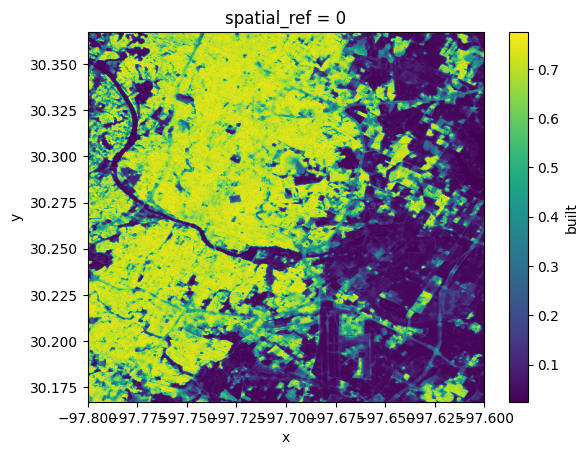

In [9]:
ds_urban.mean(dim='year').built.plot()

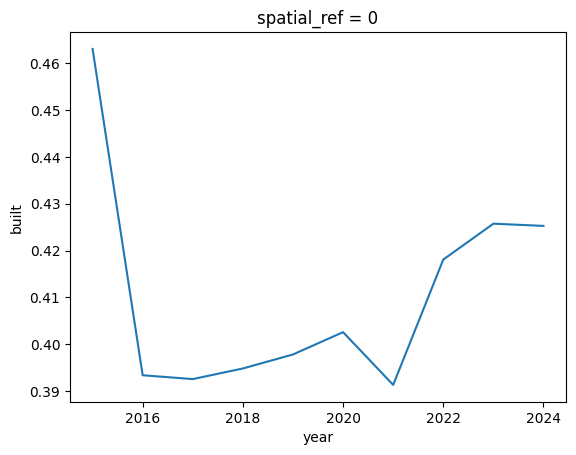

In [10]:
ds_urban.mean(dim='x').mean(dim='y').built.plot()

In [47]:
# ds_wfw['']

In [30]:
# Align ds_wfw with ds_urban by year
years_in_wfw = ds_wfw["time.year"]
# years_in_wfw
expanded_built = ds_urban["built"].sel(year=years_in_wfw).drop("year")
expanded_built

/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1621: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tmp/ipykernel_467540/210327625.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  expanded_built = ds_urban["built"].sel(year=years_in_wfw).drop("year")


<xarray.DataArray 'built' (time: 526, y: 2228, x: 2227)> Size: 21GB
dask.array<getitem, shape=(526, 2228, 2227), dtype=float64, chunksize=(81, 2228, 2227), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y            (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 4kB 2015-08-06T17:00:00 ... 2023-12-30...
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [31]:
ds_wfw['built'] = expanded_built

In [32]:
ds_wfw

<xarray.Dataset> Size: 178GB
Dimensions:       (time: 526, x: 2227, y: 2228, time_window: 13)
Coordinates:
  * time          (time) datetime64[ns] 4kB 2015-08-06T17:00:00 ... 2023-12-3...
  * x             (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y             (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref   int64 8B 0
  * time_window   (time_window) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water         (time, y, x) float64 21GB ...
    soil_ksat     (y, x) float64 40MB 0.3894 0.3894 0.3716 ... -0.9384 -0.9384
    soil_theta_r  (y, x) float64 40MB 0.05419 0.05419 0.04873 ... 0.1225 0.1225
    soil_theta_s  (y, x) float64 40MB 0.4442 0.4442 0.4335 ... 0.5323 0.5323
    dem           (y, x) float64 40MB 183.5 183.5 183.2 ... 141.5 141.5 141.6
    built         (time, y, x) float64 21GB dask.array<chunksize=(5, 2228, 2227), meta=np.ndarray>
    pr_wfw        (time, time_window, y, x) float32 136GB ...

# Input lat lon variables which would then be reduced to target box: 128 x 128

In [33]:
lat_input = ds_wfw.y
lon_input = ds_wfw.x
print(lat_input.shape, lon_input.shape)

# Create meshgrid
lon_2d, lat_2d = np.meshgrid(lon_input, lat_input)

# Print the shapes of the resulting 2D arrays
print(lat_2d.shape, lon_2d.shape)

(2228,) (2227,)
(2228, 2227) (2228, 2227)


In [34]:
min_lat = lat_2d.min()
max_lat = lat_2d.max()
min_lon = lon_2d.min()
max_lon = lon_2d.max()
print(min_lat, max_lat)
print(min_lon, max_lon)

30.167178955537565 30.36723376931098
-97.79998922397016 -97.60002424172515


In [35]:
ds_wfw['lat_2d'] = (('y', 'x'), lat_2d)
ds_wfw['lon_2d'] = (('y', 'x'), lon_2d)
ds_wfw

<xarray.Dataset> Size: 178GB
Dimensions:       (time: 526, x: 2227, y: 2228, time_window: 13)
Coordinates:
  * time          (time) datetime64[ns] 4kB 2015-08-06T17:00:00 ... 2023-12-3...
  * x             (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y             (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref   int64 8B 0
  * time_window   (time_window) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water         (time, y, x) float64 21GB ...
    soil_ksat     (y, x) float64 40MB 0.3894 0.3894 0.3716 ... -0.9384 -0.9384
    soil_theta_r  (y, x) float64 40MB 0.05419 0.05419 0.04873 ... 0.1225 0.1225
    soil_theta_s  (y, x) float64 40MB 0.4442 0.4442 0.4335 ... 0.5323 0.5323
    dem           (y, x) float64 40MB 183.5 183.5 183.2 ... 141.5 141.5 141.6
    built         (time, y, x) float64 21GB dask.array<chunksize=(5, 2228, 2227), meta=np.ndarray>
    pr_wfw        (time, time_window, y, x) float32 136GB ...
    lat_2d        (y, x) float64 40MB 30.37 30.37 30.37 ... 30.17 30.17 30.17
    lon_2d        (y, x) float64 40MB -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6

In [36]:
ds_wfw#.to_netcdf('flood_all_train_data.nc')

<xarray.Dataset> Size: 178GB
Dimensions:       (time: 526, x: 2227, y: 2228, time_window: 13)
Coordinates:
  * time          (time) datetime64[ns] 4kB 2015-08-06T17:00:00 ... 2023-12-3...
  * x             (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y             (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref   int64 8B 0
  * time_window   (time_window) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water         (time, y, x) float64 21GB ...
    soil_ksat     (y, x) float64 40MB 0.3894 0.3894 0.3716 ... -0.9384 -0.9384
    soil_theta_r  (y, x) float64 40MB 0.05419 0.05419 0.04873 ... 0.1225 0.1225
    soil_theta_s  (y, x) float64 40MB 0.4442 0.4442 0.4335 ... 0.5323 0.5323
    dem           (y, x) float64 40MB 183.5 183.5 183.2 ... 141.5 141.5 141.6
    built         (time, y, x) float64 21GB dask.array<chunksize=(5, 2228, 2227), meta=np.ndarray>
    pr_wfw        (time, time_window, y, x) float32 136GB ...
    lat_2d        (y, x) float64 40MB 30.37 30.37 30.37 ... 30.17 30.17 30.17
    lon_2d        (y, x) float64 40MB -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6

# Baseline based on JRC

In [37]:
ds_seasonality = xr.open_dataset('jrc_seasonality.nc')
ds_seasonality

<xarray.Dataset> Size: 40MB
Dimensions:      (time: 1, x: 2227, y: 2228)
Coordinates:
  * time         (time) datetime64[ns] 8B 2000-01-01
  * x            (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y            (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref  int64 8B ...
Data variables:
    seasonality  (time, y, x) float64 40MB ...

In [38]:
jrc_seasonality = ds_seasonality.seasonality

# Create the boolean mask from jrc_seasonality
jrc_mask = (jrc_seasonality <= 10) | np.isnan(jrc_seasonality)

# Ensure ds_flood_mask_ and jrc_mask are aligned
jrc_mask = jrc_mask.squeeze()  # Remove the 'time' dimension if it's singleton

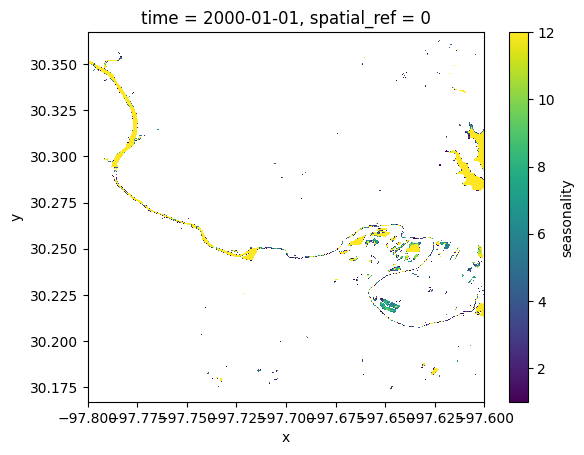

In [39]:
jrc_seasonality.plot()

# Creating a baseline for the cases when precipitation was 0 in past 12 hrs

In [40]:
estimating_if_rain_before_flood = False

if estimating_if_rain_before_flood:

    summed_data = ds_wfw.pr_wfw.chunk({'x': 100, 'y': 100, 'time': 10000}).sum(dim='time_window').sum(dim='x').sum(dim='y')

    # Compute the data (if using Dask, we need to compute)
    summed_data_computed = summed_data.compute()

    # Extract times where the summed data is zero
    times_zero = summed_data_computed.time[summed_data_computed == 0]

    # Extract times where the summed data is not zero
    times_non_zero = summed_data_computed.time[summed_data_computed != 0]

    # Convert to lists for easier inspection
    times_zero_list = times_zero.values.tolist()
    times_non_zero_list = times_non_zero.values.tolist()

    print("Times where summed data is zero:")
    print(times_zero_list)

    print("\nTimes where summed data is not zero:")
    print(times_non_zero_list)

    times_zero.to_netcdf('times_rain_zero.nc')

    times_non_zero.to_netcdf('times_rain_non_zero.nc')

In [41]:
times_zero = xr.open_dataarray('times_rain_zero.nc').drop_duplicates(dim='time')
times_zero

<xarray.DataArray 'time' (time: 459)> Size: 4kB
[459 values with dtype=datetime64[ns]]
Coordinates:
  * time         (time) datetime64[ns] 4kB 2015-08-06T17:00:00 ... 2023-12-30...
    spatial_ref  int64 8B ...

In [42]:
times_zero.values

array(['2015-08-06T17:00:00.000000000', '2015-08-16T17:00:00.000000000',
       '2015-12-04T17:00:00.000000000', '2015-12-17T17:00:00.000000000',
       '2016-01-13T17:00:00.000000000', '2016-01-23T17:00:00.000000000',
       '2016-02-02T17:00:00.000000000', '2016-02-12T17:00:00.000000000',
       '2016-02-15T17:00:00.000000000', '2016-03-03T17:00:00.000000000',
       '2016-03-13T17:00:00.000000000', '2016-03-16T17:00:00.000000000',
       '2016-04-02T17:00:00.000000000', '2016-04-15T17:00:00.000000000',
       '2016-04-22T17:00:00.000000000', '2016-05-05T17:00:00.000000000',
       '2016-06-01T17:00:00.000000000', '2016-06-21T17:00:00.000000000',
       '2016-07-01T17:00:00.000000000', '2016-07-11T17:00:00.000000000',
       '2016-07-21T17:00:00.000000000', '2016-07-24T17:00:00.000000000',
       '2016-08-10T17:00:00.000000000', '2016-09-09T17:00:00.000000000',
       '2016-09-19T17:00:00.000000000', '2016-09-22T17:00:00.000000000',
       '2016-09-29T17:00:00.000000000', '2016-10-09

In [43]:
times_non_zero = xr.open_dataarray('times_rain_non_zero.nc').drop_duplicates(dim='time')
times_non_zero

<xarray.DataArray 'time' (time: 60)> Size: 480B
[60 values with dtype=datetime64[ns]]
Coordinates:
  * time         (time) datetime64[ns] 480B 2016-01-03T17:00:00 ... 2023-10-0...
    spatial_ref  int64 8B ...

In [44]:
import xarray as xr
import pandas as pd

# Convert the time coordinates to pandas DatetimeIndex
times_zero_index = pd.DatetimeIndex(times_zero.time.values)
times_non_zero_index = pd.DatetimeIndex(times_non_zero.time.values)

# Find the times in times_zero immediately before each time in times_non_zero
previous_times = []
for time in times_non_zero_index:
    prev_time = times_zero_index[times_zero_index < time].max()
    previous_times.append(prev_time)

# Convert the list of previous times back to a pandas DatetimeIndex
previous_times_index = pd.DatetimeIndex(previous_times)

# Create a new xarray DataArray with the previous times
previous_times_dataarray = xr.DataArray(previous_times_index, dims=["time"], coords={"time": times_non_zero_index})

# Display the new DataArray
previous_times_dataarray

<xarray.DataArray (time: 60)> Size: 480B
array(['2015-12-17T17:00:00.000000000', '2016-06-01T17:00:00.000000000',
       '2017-07-16T17:00:00.000000000', '2017-10-02T17:00:00.000000000',
       '2017-10-14T17:00:00.000000000', '2018-01-17T17:00:00.000000000',
       '2018-02-04T17:00:00.000000000', '2018-04-25T17:00:00.000000000',
       '2018-04-25T17:00:00.000000000', '2018-04-25T17:00:00.000000000',
       '2018-05-12T17:00:00.000000000', '2018-06-14T17:00:00.000000000',
       '2018-07-04T17:00:00.000000000', '2018-07-19T17:00:00.000000000',
       '2018-08-08T17:00:00.000000000', '2018-08-18T17:00:00.000000000',
       '2018-09-02T17:00:00.000000000', '2018-09-19T17:00:00.000000000',
       '2018-10-04T17:00:00.000000000', '2018-10-12T17:00:00.000000000',
       '2018-11-26T17:00:00.000000000', '2018-12-03T17:00:00.000000000',
       '2019-01-05T17:00:00.000000000', '2019-05-22T17:00:00.000000000',
       '2019-05-22T17:00:00.000000000', '2019-06-14T17:00:00.000000000',
       '2019-07-09T17:00:00.000000000', '2019-08-23T17:00:00.000000000',
       '2019-09-07T17:00:00.000000000', '2019-09-19T17:00:00.000000000',
       '2019-09-27T17:00:00.000000000', '2020-02-01T17:00:00.000000000',
       '2020-05-04T17:00:00.000000000', '2020-05-19T17:00:00.000000000',
       '2020-05-19T17:00:00.000000000', '2020-08-02T17:00:00.000000000',
       '2020-08-14T17:00:00.000000000', '2020-09-26T17:00:00.000000000',
       '2020-11-20T17:00:00.000000000', '2021-01-09T17:00:00.000000000',
       '2021-02-03T17:00:00.000000000', '2021-03-15T17:00:00.000000000',
       '2021-03-20T17:00:00.000000000', '2021-07-15T17:00:00.000000000',
       '2021-10-08T17:00:00.000000000', '2021-12-12T17:00:00.000000000',
       '2022-03-20T17:00:00.000000000', '2022-03-25T17:00:00.000000000',
       '2022-05-14T17:00:00.000000000', '2022-06-13T17:00:00.000000000',
       '2022-07-30T17:00:00.000000000', '2022-08-12T17:00:00.000000000',
       '2022-09-06T17:00:00.000000000', '2022-09-21T17:00:00.000000000',
       '2022-11-02T17:00:00.000000000', '2023-04-11T17:00:00.000000000',
       '2023-06-03T17:00:00.000000000', '2023-06-03T17:00:00.000000000',
       '2023-07-20T17:00:00.000000000', '2023-09-28T17:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 480B 2016-01-03T17:00:00 ... 2023-10-03T17...

In [45]:
ds_wfw_with_rain_before = ds_wfw.drop_duplicates(dim='time').sel(time=times_non_zero.values)
ds_wfw_with_rain_before

/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1621: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.Dataset> Size: 20GB
Dimensions:       (time: 60, x: 2227, y: 2228, time_window: 13)
Coordinates:
  * time          (time) datetime64[ns] 480B 2016-01-03T17:00:00 ... 2023-10-...
  * x             (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y             (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref   int64 8B 0
  * time_window   (time_window) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water         (time, y, x) float64 2GB ...
    soil_ksat     (y, x) float64 40MB 0.3894 0.3894 0.3716 ... -0.9384 -0.9384
    soil_theta_r  (y, x) float64 40MB 0.05419 0.05419 0.04873 ... 0.1225 0.1225
    soil_theta_s  (y, x) float64 40MB 0.4442 0.4442 0.4335 ... 0.5323 0.5323
    dem           (y, x) float64 40MB 183.5 183.5 183.2 ... 141.5 141.5 141.6
    built         (time, y, x) float64 2GB dask.array<chunksize=(2, 2228, 2227), meta=np.ndarray>
    pr_wfw        (time, time_window, y, x) float32 15GB ...
    lat_2d        (y, x) float64 40MB 30.37 30.37 30.37 ... 30.17 30.17 30.17
    lon_2d        (y, x) float64 40MB -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6

In [46]:
# if False:
#     ds_perm_water.mean(dim='time').plot()
#     ds_perm_water.to_dataset().to_netcdf('water_baseline.nc')
# ds_perm_water = xr.open_dataset('water_baseline.nc')
# ds_perm_water.water.mean(dim='time').plot()

In [47]:
ds_flood_mask_ = ds_wfw.water.drop_duplicates(dim='time').sel(time=times_non_zero.values)
# ds_flood_mask = ds_flood_mask_ - ds_perm_water.water.values
ds_flood_mask__ = ds_flood_mask_.where(jrc_mask, other=np.nan)
ds_flood_mask = ds_flood_mask__ - ds_flood_mask__.mean(dim='time')
ds_flood_mask

<xarray.DataArray 'water' (time: 60, y: 2228, x: 2227)> Size: 2GB
array([[[        nan,         nan,         nan, ...,  0.00899929,
          0.01252212,  0.01303803],
        [        nan,         nan,         nan, ...,  0.00422877,
          0.00755399,  0.01303803],
        [        nan,         nan,         nan, ...,  0.00274801,
          0.00365548,  0.01031247],
        ...,
        [ 0.01066496,  0.01887738,  0.02038657, ...,  0.00480534,
          0.00462067,  0.0032084 ],
        [ 0.01215306,  0.0191831 ,  0.01832894, ...,  0.00290563,
          0.00267072,  0.00140927],
        [ 0.00526339,  0.01088645,  0.0145751 , ..., -0.00068351,
         -0.00012782, -0.00048292]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,  0.00247979,
          0.00329427,  0.00650013],
        [        nan,         nan,         nan, ...,  0.00468912,
          0.00454606,  0.00520986],
        [        nan,         nan,         nan, ...,  0.00774362,
          0.00721566,  0.00383877]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time         (time) datetime64[ns] 480B 2016-01-03T17:00:00 ... 2023-10-0...
  * x            (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y            (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref  int64 8B 0

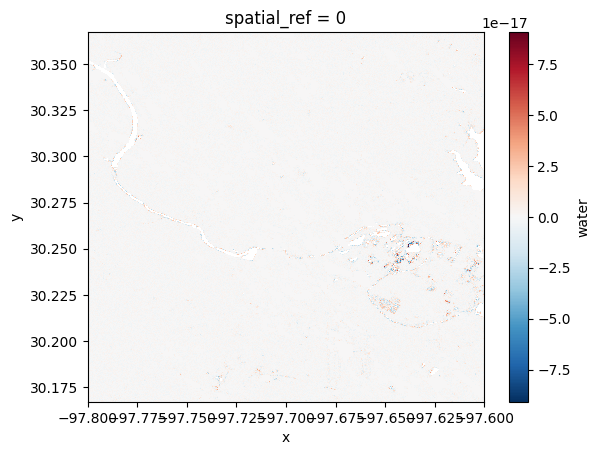

In [48]:
ds_flood_mask.mean(dim='time').plot()

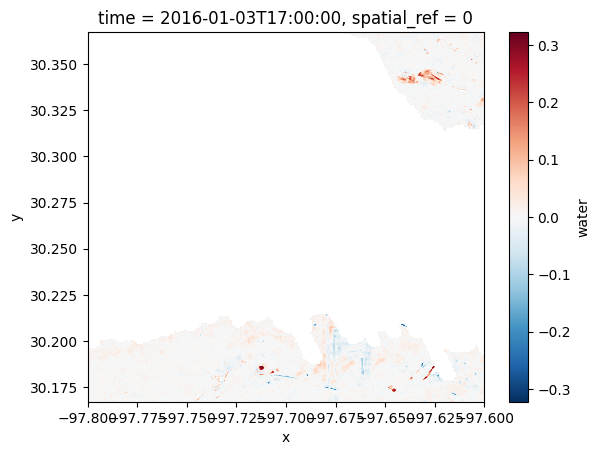

In [49]:
ds_flood_mask.isel(time=0).plot()

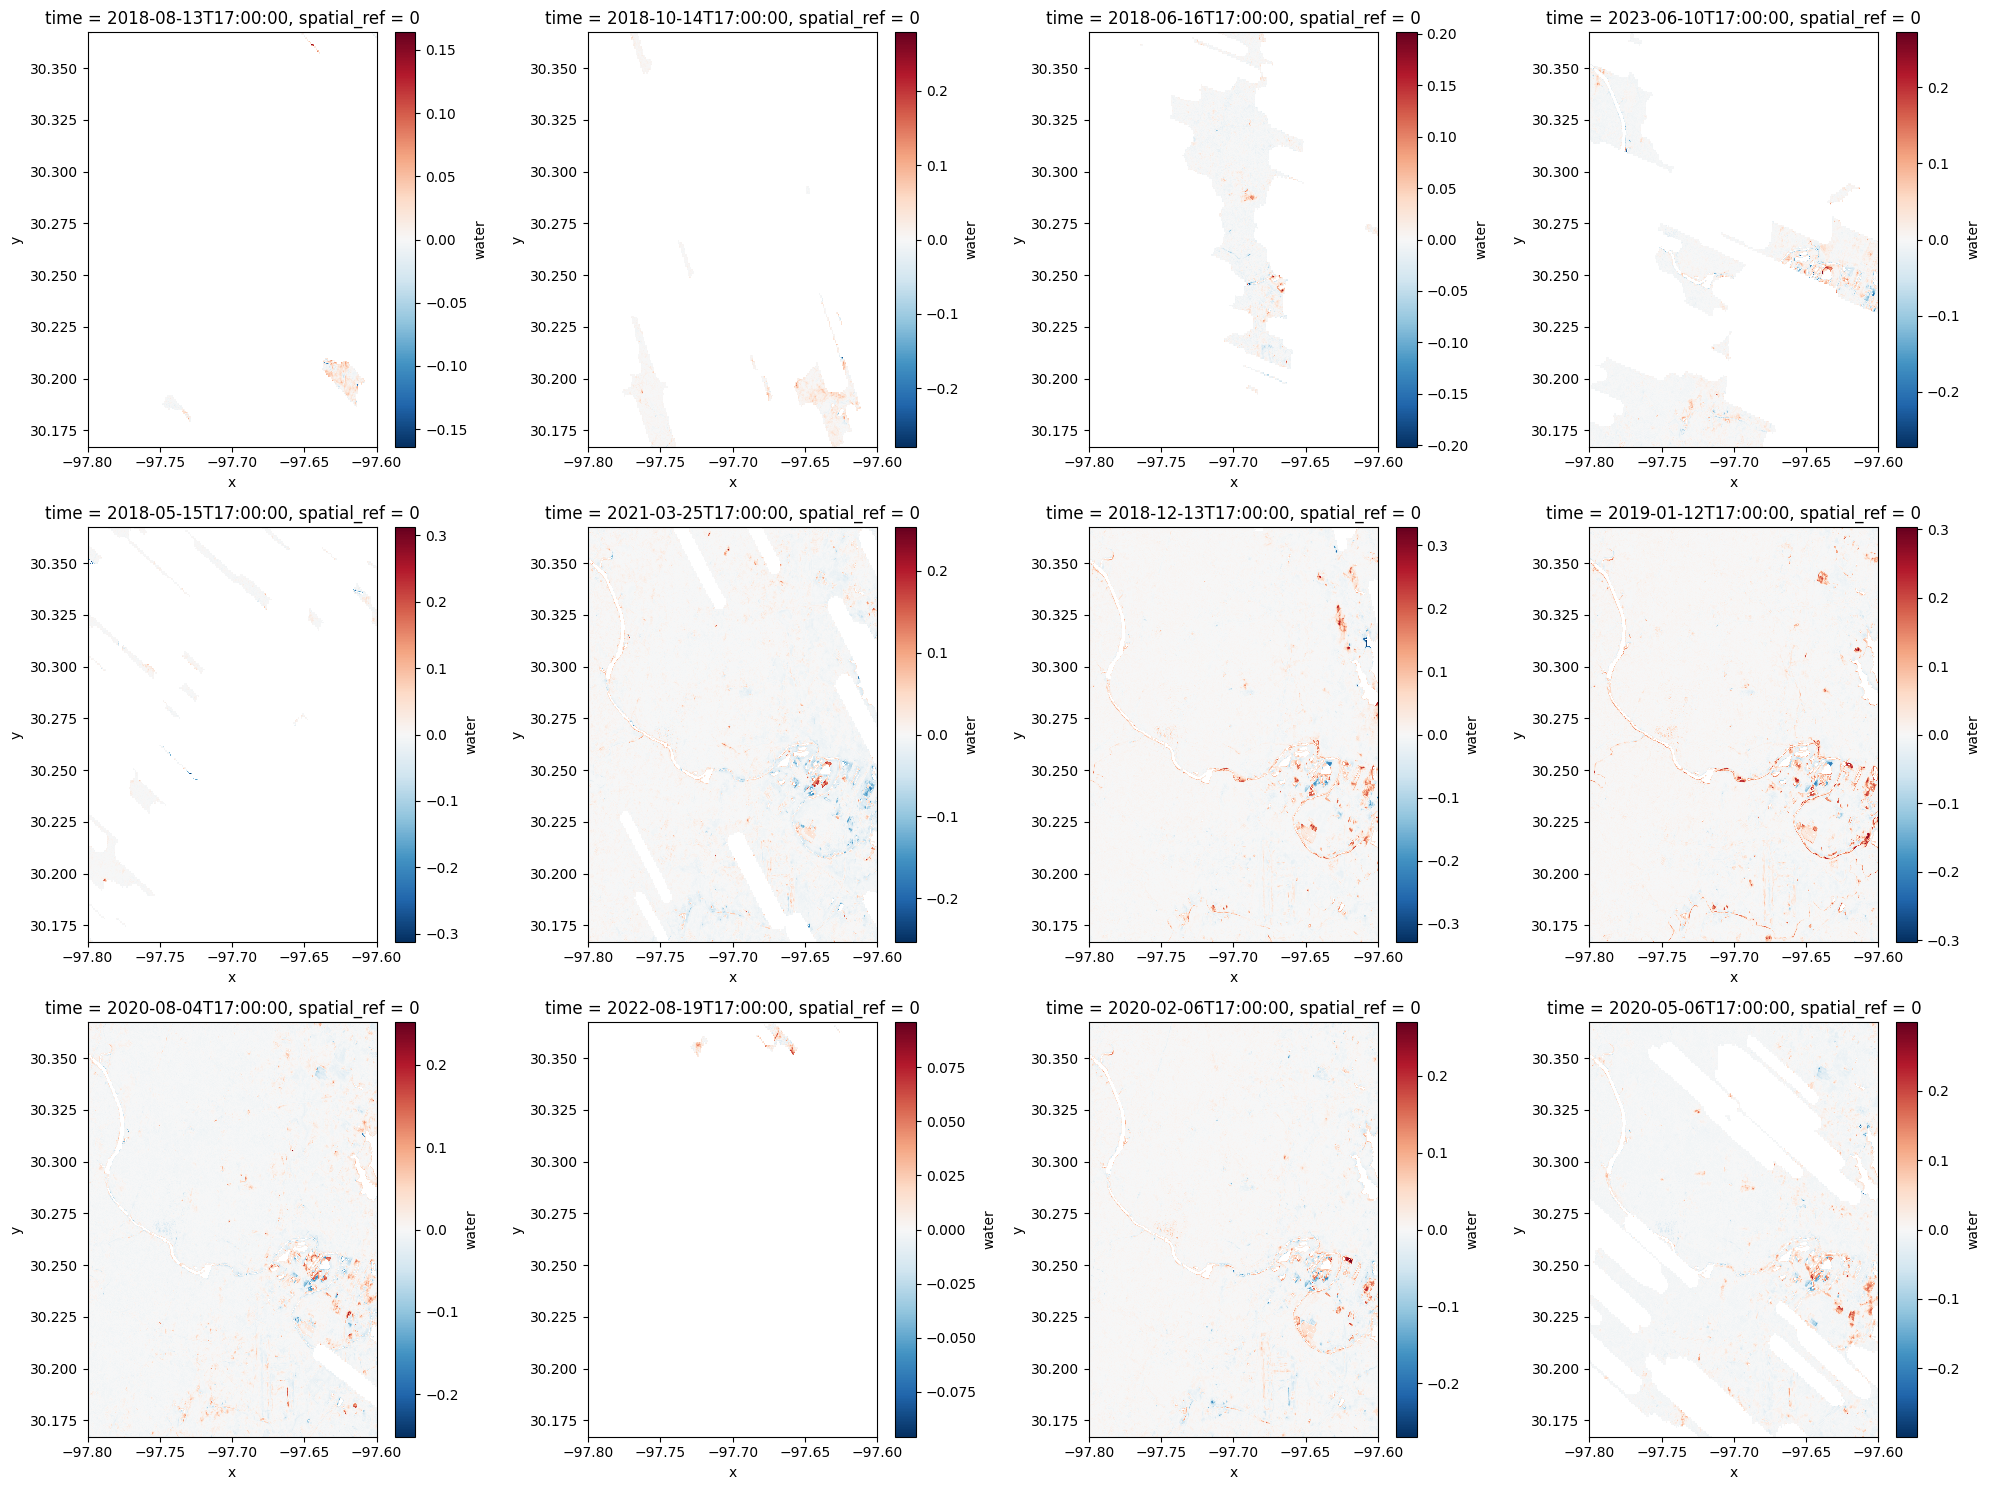

In [48]:
# Get the total number of time steps
total_time_steps = ds_flood_mask.time.size

# Generate 12 unique random time indices
random_time_indices = np.random.choice(total_time_steps, 12, replace=False)

# Create a 3x4 subplot
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for i, ax in enumerate(axes.flatten()):
    ds_flood_mask.isel(time=random_time_indices[i]).plot(ax=ax)
    #ax.set_title(f"Time index: {random_time_indices[i]}")

plt.tight_layout()
plt.show()

In [49]:
# # Get the total number of time steps
# total_time_steps = ds_flood_mask.time.size

# # Generate 12 unique random time indices
# random_time_indices = np.random.choice(total_time_steps, 12, replace=False)

# # Create a 3x4 subplot
# fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# for i, ax in enumerate(axes.flatten()):
#     ds_flood_mask.isel(time=random_time_indices[i]).plot(ax=ax)
#     #ax.set_title(f"Time index: {random_time_indices[i]}")

# plt.tight_layout()
# plt.show()

In [151]:
# # Get the total number of time steps
# total_time_steps = ds_flood_mask.time.size

# # Generate 12 unique random time indices
# random_time_indices = np.random.choice(total_time_steps, 12, replace=False)

# # Create a 3x4 subplot
# fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# for i, ax in enumerate(axes.flatten()):
#     ds_flood_mask.isel(time=random_time_indices[i]).plot(ax=ax)
#     #ax.set_title(f"Time index: {random_time_indices[i]}")

# plt.tight_layout()
# plt.show()

In [50]:
ds_flood_mask

<xarray.DataArray 'water' (time: 60, y: 2228, x: 2227)> Size: 2GB
array([[[        nan,         nan,         nan, ...,  0.00899929,
          0.01252212,  0.01303803],
        [        nan,         nan,         nan, ...,  0.00422877,
          0.00755399,  0.01303803],
        [        nan,         nan,         nan, ...,  0.00274801,
          0.00365548,  0.01031247],
        ...,
        [ 0.01066496,  0.01887738,  0.02038657, ...,  0.00480534,
          0.00462067,  0.0032084 ],
        [ 0.01215306,  0.0191831 ,  0.01832894, ...,  0.00290563,
          0.00267072,  0.00140927],
        [ 0.00526339,  0.01088645,  0.0145751 , ..., -0.00068351,
         -0.00012782, -0.00048292]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,  0.00247979,
          0.00329427,  0.00650013],
        [        nan,         nan,         nan, ...,  0.00468912,
          0.00454606,  0.00520986],
        [        nan,         nan,         nan, ...,  0.00774362,
          0.00721566,  0.00383877]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time         (time) datetime64[ns] 480B 2016-01-03T17:00:00 ... 2023-10-0...
  * x            (x) float64 18kB -97.8 -97.8 -97.8 -97.8 ... -97.6 -97.6 -97.6
  * y            (y) float64 18kB 30.37 30.37 30.37 30.37 ... 30.17 30.17 30.17
    spatial_ref  int64 8B 0

# Preparing Supervised Learning data with full input and limited target

In [51]:
import numpy as np
import dask.array as da
from scipy.ndimage import zoom

def bilinear_interpolate_dask(input_array, new_shape):
    # Convert input array to Dask array
    dask_array = da.from_array(input_array, chunks=(input_array.shape[0] // 2, input_array.shape[1] // 2))
    
    # Calculate the zoom factors
    height_factor = new_shape[0] / input_array.shape[0]
    width_factor = new_shape[1] / input_array.shape[1]
    
    # Apply zoom using SciPy's zoom function
    resized_array = dask_array.map_blocks(zoom, zoom=(height_factor, width_factor), order=1)
    
    # Compute the result
    result = resized_array.compute()
    
    return result


In [52]:
ds_wfw_with_rain_before_ = ds_wfw_with_rain_before.isel(x=slice(0,2048)).isel(y=slice(0,2048))
ds_wfw_with_rain_before_

<xarray.Dataset> Size: 17GB
Dimensions:       (time: 60, x: 2048, y: 2048, time_window: 13)
Coordinates:
  * time          (time) datetime64[ns] 480B 2016-01-03T17:00:00 ... 2023-10-...
  * x             (x) float64 16kB -97.8 -97.8 -97.8 ... -97.62 -97.62 -97.62
  * y             (y) float64 16kB 30.37 30.37 30.37 30.37 ... 30.18 30.18 30.18
    spatial_ref   int64 8B 0
  * time_window   (time_window) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water         (time, y, x) float64 2GB ...
    soil_ksat     (y, x) float64 34MB 0.3894 0.3894 0.3716 ... -0.699 -0.699
    soil_theta_r  (y, x) float64 34MB 0.05419 0.05419 0.04873 ... 0.1214 0.1214
    soil_theta_s  (y, x) float64 34MB 0.4442 0.4442 0.4335 ... 0.5386 0.5386
    dem           (y, x) float64 34MB 183.5 183.5 183.2 ... 156.8 157.0 157.1
    built         (time, y, x) float64 2GB dask.array<chunksize=(2, 2048, 2048), meta=np.ndarray>
    pr_wfw        (time, time_window, y, x) float32 13GB ...
    lat_2d        (y, x) float64 34MB 30.37 30.37 30.37 ... 30.18 30.18 30.18
    lon_2d        (y, x) float64 34MB -97.8 -97.8 -97.8 ... -97.62 -97.62 -97.62

In [53]:
input1 = ds_wfw_with_rain_before_.isel(time=0).pr_wfw.sum(dim='time_window').values
print(input1.shape)

input2 = ds_wfw_with_rain_before_.isel(time=0).soil_ksat.values
input3 = ds_wfw_with_rain_before_.isel(time=0).soil_theta_r.values
input4 = ds_wfw_with_rain_before_.isel(time=0).soil_theta_s.values
input5 = ds_wfw_with_rain_before_.isel(time=0).dem.values
input6 = ds_wfw_with_rain_before_.isel(time=0).built.values

target_ = ds_flood_mask.isel(time=0).isel(x=slice(128,256)).isel(y=slice(128,256))
lat_, lon_ = ds_wfw_with_rain_before_.isel(x=slice(128,256)).isel(y=slice(128,256)).lat_2d, ds_wfw.isel(x=slice(128,256)).isel(y=slice(128,256)).lon_2d
print(lat_.shape)
lat = bilinear_interpolate_dask(lat_, (input2.shape[0], input2.shape[1]))
lon = bilinear_interpolate_dask(lon_, (input2.shape[0], input2.shape[1]))

target = target_.values
print(target.shape)
print(np.sum(np.isnan(target)), np.sum(np.isnan(input1)))


(2048, 2048)
(128, 128)
(128, 128)
16384 0


In [54]:
np.sum(np.isnan(ds_wfw_with_rain_before_.isel(time=0).pr_wfw.sum(dim='time_window'))).values

array(0)

# Min max computation

In [58]:
if False:

    # Initialize variables to store global min and max values
    global_min_max = {
        "input1_min": float('inf'), "input1_max": float('-inf'),
        "input2_min": float('inf'), "input2_max": float('-inf'),
        "input3_min": float('inf'), "input3_max": float('-inf'),
        "input4_min": float('inf'), "input4_max": float('-inf'),
        "input5_min": float('inf'), "input5_max": float('-inf'),
        "input6_min": float('inf'), "input6_max": float('-inf'),
        "lat_min": float('inf'), "lat_max": float('-inf'),
        "lon_min": float('inf'), "lon_max": float('-inf'),
        "target_min": float('inf'), "target_max": float('-inf')
    }

    # Step 1: Calculate global min and max across all time steps

    input1 = ds_wfw_with_rain_before_.pr_wfw.sum(dim='time_window').values
    input2 = ds_wfw_with_rain_before_.soil_ksat.values
    input3 = ds_wfw_with_rain_before_.soil_theta_r.values
    input4 = ds_wfw_with_rain_before_.soil_theta_s.values
    input5 = ds_wfw_with_rain_before_.dem.values
    input6 = ds_wfw_with_rain_before_.built.values
    lat2d = ds_wfw_with_rain_before_.lat_2d.values
    lon2d = ds_wfw_with_rain_before_.lon_2d.values

    # Update global min and max for each variable
    global_min_max["input1_min"] = min(global_min_max["input1_min"], np.nanmin(input1))
    global_min_max["input1_max"] = max(global_min_max["input1_max"], np.nanmax(input1))

    global_min_max["input2_min"] = min(global_min_max["input2_min"], np.nanmin(input2))
    global_min_max["input2_max"] = max(global_min_max["input2_max"], np.nanmax(input2))

    global_min_max["input3_min"] = min(global_min_max["input3_min"], np.nanmin(input3))
    global_min_max["input3_max"] = max(global_min_max["input3_max"], np.nanmax(input3))

    global_min_max["input4_min"] = min(global_min_max["input4_min"], np.nanmin(input4))
    global_min_max["input4_max"] = max(global_min_max["input4_max"], np.nanmax(input4))

    global_min_max["input5_min"] = min(global_min_max["input5_min"], np.nanmin(input5))
    global_min_max["input5_max"] = max(global_min_max["input5_max"], np.nanmax(input5))

    global_min_max["input6_min"] = min(global_min_max["input6_min"], np.nanmin(input6))
    global_min_max["input6_max"] = max(global_min_max["input6_max"], np.nanmax(input6))

    global_min_max["lon_min"] = min(global_min_max["lon_min"], np.nanmin(lon2d))
    global_min_max["lon_max"] = max(global_min_max["lon_max"], np.nanmax(lon2d))

    global_min_max["lat_min"] = min(global_min_max["lat_min"], np.nanmin(lat2d))
    global_min_max["lat_max"] = max(global_min_max["lat_max"], np.nanmax(lat2d))


    # Assuming target is independent of time and based on flood mask, you can also check global min-max of target here
    target_slice = ds_flood_mask.values
    global_min_max["target_min"] = min(global_min_max["target_min"], np.nanmin(target_slice))
    global_min_max["target_max"] = max(global_min_max["target_max"], np.nanmax(target_slice))


In [59]:
global_min_max = {'input1_min': 0.0,
 'input1_max': 86.47118,
 'input2_min': -1.5628526210784912,
 'input2_max': 1.482730746269226,
 'input3_min': 0.013253905810415745,
 'input3_max': 0.22099609673023224,
 'input4_min': 0.39643242955207825,
 'input4_max': 0.6264151334762573,
 'input5_min': 117.87999725341797,
 'input5_max': 283.3416748046875,
 'input6_min': 0.021104731896360005,
 'input6_max': 0.7919729097823923,
 'lat_min': 30.183348630651714,
 'lat_max': 30.36723376931098,
 'lon_min': -97.79998922397016,
 'lon_max': -97.6161040853109,
 'target_min': -0.3453484854932564,
 'target_max': 0.33696593441929895}

global_min_max

{'input1_min': 0.0,
 'input1_max': 86.47118,
 'input2_min': -1.5628526210784912,
 'input2_max': 1.482730746269226,
 'input3_min': 0.013253905810415745,
 'input3_max': 0.22099609673023224,
 'input4_min': 0.39643242955207825,
 'input4_max': 0.6264151334762573,
 'input5_min': 117.87999725341797,
 'input5_max': 283.3416748046875,
 'input6_min': 0.021104731896360005,
 'input6_max': 0.7919729097823923,
 'lat_min': 30.183348630651714,
 'lat_max': 30.36723376931098,
 'lon_min': -97.79998922397016,
 'lon_max': -97.6161040853109,
 'target_min': -0.3453484854932564,
 'target_max': 0.33696593441929895}

In [60]:
if False:

    # Step 2: Normalize the data using the global min and max values
    def min_max_normalize(data, global_min, global_max):
        return (data - global_min) / (global_max - global_min)

    # Initialize lists to store normalized data
    input1_list = []
    input2_list = []
    input3_list = []
    input4_list = []
    input5_list = []
    input6_list = []
    target_list = []
    lat_list = []
    lon_list = []

    window_size = 128

    # Loop over the time dimension
    for t in tqdm(range(ds_wfw_with_rain_before_.dims['time'])):
        # Get the variables for the current time step
        input1 = ds_wfw_with_rain_before_.isel(time=t).pr_wfw.sum(dim='time_window').values
        input2 = ds_wfw_with_rain_before_.isel(time=t).soil_ksat.values
        input3 = ds_wfw_with_rain_before_.isel(time=t).soil_theta_r.values
        input4 = ds_wfw_with_rain_before_.isel(time=t).soil_theta_s.values
        input5 = ds_wfw_with_rain_before_.isel(time=t).dem.values
        input6 = ds_wfw_with_rain_before_.isel(time=t).built.values

        # Normalize the inputs using global min and max
        input1 = min_max_normalize(input1, global_min_max["input1_min"], global_min_max["input1_max"])
        input2 = min_max_normalize(input2, global_min_max["input2_min"], global_min_max["input2_max"])
        input3 = min_max_normalize(input3, global_min_max["input3_min"], global_min_max["input3_max"])
        input4 = min_max_normalize(input4, global_min_max["input4_min"], global_min_max["input4_max"])
        input5 = min_max_normalize(input5, global_min_max["input5_min"], global_min_max["input5_max"])
        input6 = min_max_normalize(input6, global_min_max["input6_min"], global_min_max["input6_max"])

        # Loop over x and y with a sliding window of 128x128
        for i in range(0, input1.shape[0] - window_size + 1, window_size):
            for j in range(0, input1.shape[1] - window_size + 1, window_size):
                # Slice the arrays
                target_slice = ds_flood_mask.isel(time=t).isel(x=slice(i, i + window_size), y=slice(j, j + window_size)).values
                lat_slice = ds_wfw_with_rain_before_.isel(x=slice(i, i + window_size), y=slice(j, j + window_size)).lat_2d.values
                lon_slice = ds_wfw_with_rain_before_.isel(x=slice(i, i + window_size), y=slice(j, j + window_size)).lon_2d.values
                
                lat_slice = min_max_normalize(lat_slice, global_min_max["lat_min"], global_min_max["lat_max"])
                lon_slice = min_max_normalize(lon_slice, global_min_max["lon_min"], global_min_max["lon_max"])

                # Normalize the target using global min and max
                target_slice = min_max_normalize(target_slice, global_min_max["target_min"], global_min_max["target_max"])

                # Check if the target slice contains any NaNs
                if np.sum(np.isnan(target_slice)) == 0:
                    # Resize lat and lon if needed (using bilinear interpolation as per the original code)
                    lat_resized = bilinear_interpolate_dask(lat_slice, (input1.shape[0], input1.shape[1]))
                    lon_resized = bilinear_interpolate_dask(lon_slice, (input1.shape[0], input1.shape[1]))

                    # Append the slices to the lists
                    input1_list.append(input1)
                    input2_list.append(input2)
                    input3_list.append(input3)
                    input4_list.append(input4)
                    input5_list.append(input5)
                    input6_list.append(input6)
                    target_list.append(target_slice)
                    lat_list.append(lat_resized)
                    lon_list.append(lon_resized)

    # Print the lengths of each list to verify
    print(f'Number of valid windows: {len(target_list)}')

In [64]:
import torch
import os

def min_max_normalize(data, global_min, global_max):
    return (data - global_min) / (global_max - global_min)

# Function to concatenate the inputs and save as .pt file
def save_as_pt(inputs, target, filename):
    inputs_tensor = torch.tensor(np.stack(inputs, axis=0))  # Stack inputs along a new dimension (channels)
    target_tensor = torch.tensor(target)
    data = (inputs_tensor, target_tensor)
    torch.save(data, filename)

window_size = 128

# Loop over the time dimension
for t in tqdm(range(ds_wfw_with_rain_before_.dims['time'])):
    # Get the variables for the current time step
    input1 = ds_wfw_with_rain_before_.isel(time=t).pr_wfw.sum(dim='time_window').values
    input2 = ds_wfw_with_rain_before_.isel(time=t).soil_ksat.values
    input3 = ds_wfw_with_rain_before_.isel(time=t).soil_theta_r.values
    input4 = ds_wfw_with_rain_before_.isel(time=t).soil_theta_s.values
    input5 = ds_wfw_with_rain_before_.isel(time=t).dem.values
    input6 = ds_wfw_with_rain_before_.isel(time=t).built.values

    # Normalize the inputs using global min and max
    input1 = min_max_normalize(input1, global_min_max["input1_min"], global_min_max["input1_max"])
    input2 = min_max_normalize(input2, global_min_max["input2_min"], global_min_max["input2_max"])
    input3 = min_max_normalize(input3, global_min_max["input3_min"], global_min_max["input3_max"])
    input4 = min_max_normalize(input4, global_min_max["input4_min"], global_min_max["input4_max"])
    input5 = min_max_normalize(input5, global_min_max["input5_min"], global_min_max["input5_max"])
    input6 = min_max_normalize(input6, global_min_max["input6_min"], global_min_max["input6_max"])

    # Loop over x and y with a sliding window of 128x128
    for i in range(0, input1.shape[0] - window_size + 1, window_size):
        for j in range(0, input1.shape[1] - window_size + 1, window_size):
            # Slice the arrays
            target_slice = ds_flood_mask.isel(time=t).isel(x=slice(i, i + window_size), y=slice(j, j + window_size)).values
            lat_slice = ds_wfw_with_rain_before_.isel(x=slice(i, i + window_size), y=slice(j, j + window_size)).lat_2d.values
            lon_slice = ds_wfw_with_rain_before_.isel(x=slice(i, i + window_size), y=slice(j, j + window_size)).lon_2d.values
            
            lat_slice = min_max_normalize(lat_slice, global_min_max["lat_min"], global_min_max["lat_max"])
            lon_slice = min_max_normalize(lon_slice, global_min_max["lon_min"], global_min_max["lon_max"])

            # Normalize the target using global min and max
            target_slice = min_max_normalize(target_slice, global_min_max["target_min"], global_min_max["target_max"])

            # Check if the target slice contains any NaNs
            if np.sum(np.isnan(target_slice)) == 0:
                # Resize lat and lon if needed (using bilinear interpolation as per the original code)
                lat_resized = bilinear_interpolate_dask(lat_slice, (input1.shape[0], input1.shape[1]))
                lon_resized = bilinear_interpolate_dask(lon_slice, (input1.shape[0], input1.shape[1]))

                # Concatenate all input channels into a single array with shape (channels, height, width)
                input_combined = np.stack([input1, input2, input3, input4, input5, input6, lat_resized, lon_resized], axis=0)
                
                # Generate filename
                filename = f'data_window_t{t}_i{i}_j{j}.pt'

                # Check if file already exists
                if not os.path.exists(filename):
                    # Save the input_combined and target_slice as a .pt file
                    save_as_pt(input_combined, target_slice, filename)
                else:
                    print(f'Skipping {filename} as it already exists.')

# Print confirmation message
print('Processing complete.')

/tmp/ipykernel_467540/791362359.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in tqdm(range(ds_wfw_with_rain_before_.dims['time'])):
  0%|          | 0/60 [00:00<?, ?it/s]

Skipping data_window_t0_i0_j1920.pt as it already exists.
Skipping data_window_t0_i128_j1920.pt as it already exists.
Skipping data_window_t0_i256_j1920.pt as it already exists.
Skipping data_window_t0_i384_j1920.pt as it already exists.
Skipping data_window_t0_i512_j1920.pt as it already exists.
Skipping data_window_t0_i640_j1792.pt as it already exists.
Skipping data_window_t0_i640_j1920.pt as it already exists.
Skipping data_window_t0_i768_j1792.pt as it already exists.
Skipping data_window_t0_i768_j1920.pt as it already exists.
Skipping data_window_t0_i896_j1792.pt as it already exists.
Skipping data_window_t0_i896_j1920.pt as it already exists.
Skipping data_window_t0_i1024_j1920.pt as it already exists.
Skipping data_window_t0_i1408_j1920.pt as it already exists.
Skipping data_window_t0_i1536_j1920.pt as it already exists.
Skipping data_window_t0_i1664_j0.pt as it already exists.
Skipping data_window_t0_i1664_j1920.pt as it already exists.
Skipping data_window_t0_i1792_j0.pt as i

  2%|▏         | 1/60 [00:03<03:26,  3.51s/it]

Skipping data_window_t0_i1920_j256.pt as it already exists.
Skipping data_window_t0_i1920_j384.pt as it already exists.


  3%|▎         | 2/60 [00:05<02:31,  2.61s/it]

Skipping data_window_t2_i0_j1024.pt as it already exists.
Skipping data_window_t2_i0_j1152.pt as it already exists.
Skipping data_window_t2_i128_j1152.pt as it already exists.


  7%|▋         | 4/60 [00:10<02:21,  2.53s/it]

Skipping data_window_t4_i0_j0.pt as it already exists.
Skipping data_window_t4_i0_j384.pt as it already exists.
Skipping data_window_t4_i0_j512.pt as it already exists.
Skipping data_window_t4_i0_j896.pt as it already exists.
Skipping data_window_t4_i0_j1024.pt as it already exists.
Skipping data_window_t4_i0_j1152.pt as it already exists.
Skipping data_window_t4_i0_j1280.pt as it already exists.
Skipping data_window_t4_i0_j1408.pt as it already exists.
Skipping data_window_t4_i0_j1536.pt as it already exists.
Skipping data_window_t4_i0_j1664.pt as it already exists.
Skipping data_window_t4_i0_j1792.pt as it already exists.
Skipping data_window_t4_i0_j1920.pt as it already exists.
Skipping data_window_t4_i128_j0.pt as it already exists.
Skipping data_window_t4_i128_j1024.pt as it already exists.
Skipping data_window_t4_i128_j1152.pt as it already exists.
Skipping data_window_t4_i128_j1280.pt as it already exists.
Skipping data_window_t4_i128_j1408.pt as it already exists.
Skipping data

  8%|▊         | 5/60 [00:26<06:55,  7.56s/it]

Skipping data_window_t4_i1920_j1408.pt as it already exists.
Skipping data_window_t4_i1920_j1536.pt as it already exists.
Skipping data_window_t4_i1920_j1792.pt as it already exists.
Skipping data_window_t5_i0_j0.pt as it already exists.
Skipping data_window_t5_i0_j384.pt as it already exists.
Skipping data_window_t5_i0_j512.pt as it already exists.
Skipping data_window_t5_i0_j896.pt as it already exists.
Skipping data_window_t5_i0_j1024.pt as it already exists.
Skipping data_window_t5_i0_j1152.pt as it already exists.
Skipping data_window_t5_i0_j1280.pt as it already exists.
Skipping data_window_t5_i0_j1408.pt as it already exists.
Skipping data_window_t5_i0_j1536.pt as it already exists.
Skipping data_window_t5_i0_j1664.pt as it already exists.
Skipping data_window_t5_i0_j1792.pt as it already exists.
Skipping data_window_t5_i0_j1920.pt as it already exists.
Skipping data_window_t5_i128_j0.pt as it already exists.
Skipping data_window_t5_i128_j1024.pt as it already exists.
Skipping d

 10%|█         | 6/60 [00:45<10:02, 11.16s/it]

Skipping data_window_t5_i1920_j1408.pt as it already exists.
Skipping data_window_t5_i1920_j1536.pt as it already exists.
Skipping data_window_t5_i1920_j1792.pt as it already exists.
Skipping data_window_t6_i0_j0.pt as it already exists.
Skipping data_window_t6_i0_j384.pt as it already exists.
Skipping data_window_t6_i0_j512.pt as it already exists.
Skipping data_window_t6_i0_j896.pt as it already exists.
Skipping data_window_t6_i0_j1024.pt as it already exists.
Skipping data_window_t6_i0_j1152.pt as it already exists.
Skipping data_window_t6_i0_j1280.pt as it already exists.
Skipping data_window_t6_i0_j1408.pt as it already exists.
Skipping data_window_t6_i0_j1536.pt as it already exists.
Skipping data_window_t6_i0_j1664.pt as it already exists.
Skipping data_window_t6_i0_j1792.pt as it already exists.
Skipping data_window_t6_i0_j1920.pt as it already exists.
Skipping data_window_t6_i128_j0.pt as it already exists.
Skipping data_window_t6_i128_j1024.pt as it already exists.
Skipping d

 12%|█▏        | 7/60 [00:59<10:51, 12.30s/it]

Skipping data_window_t6_i1920_j1536.pt as it already exists.
Skipping data_window_t6_i1920_j1792.pt as it already exists.
Skipping data_window_t7_i0_j384.pt as it already exists.
Skipping data_window_t7_i0_j512.pt as it already exists.
Skipping data_window_t7_i0_j1024.pt as it already exists.
Skipping data_window_t7_i0_j1792.pt as it already exists.
Skipping data_window_t7_i0_j1920.pt as it already exists.
Skipping data_window_t7_i128_j1152.pt as it already exists.
Skipping data_window_t7_i128_j1792.pt as it already exists.
Skipping data_window_t7_i128_j1920.pt as it already exists.
Skipping data_window_t7_i256_j0.pt as it already exists.
Skipping data_window_t7_i256_j768.pt as it already exists.
Skipping data_window_t7_i256_j1920.pt as it already exists.
Skipping data_window_t7_i384_j384.pt as it already exists.
Skipping data_window_t7_i384_j640.pt as it already exists.
Skipping data_window_t7_i384_j768.pt as it already exists.
Skipping data_window_t7_i384_j896.pt as it already exists

 13%|█▎        | 8/60 [01:10<10:05, 11.65s/it]

Skipping data_window_t7_i1920_j1408.pt as it already exists.
Skipping data_window_t7_i1920_j1536.pt as it already exists.
Skipping data_window_t7_i1920_j1792.pt as it already exists.
Skipping data_window_t8_i0_j0.pt as it already exists.
Skipping data_window_t8_i0_j384.pt as it already exists.
Skipping data_window_t8_i0_j512.pt as it already exists.
Skipping data_window_t8_i0_j896.pt as it already exists.
Skipping data_window_t8_i0_j1024.pt as it already exists.
Skipping data_window_t8_i0_j1152.pt as it already exists.
Skipping data_window_t8_i0_j1280.pt as it already exists.
Skipping data_window_t8_i0_j1408.pt as it already exists.
Skipping data_window_t8_i0_j1536.pt as it already exists.
Skipping data_window_t8_i0_j1664.pt as it already exists.
Skipping data_window_t8_i0_j1792.pt as it already exists.
Skipping data_window_t8_i0_j1920.pt as it already exists.
Skipping data_window_t8_i128_j0.pt as it already exists.
Skipping data_window_t8_i128_j1024.pt as it already exists.
Skipping d

 15%|█▌        | 9/60 [01:27<11:32, 13.59s/it]

Skipping data_window_t8_i1920_j1536.pt as it already exists.
Skipping data_window_t8_i1920_j1792.pt as it already exists.


 18%|█▊        | 11/60 [01:34<06:40,  8.18s/it]

Skipping data_window_t11_i896_j384.pt as it already exists.
Skipping data_window_t11_i896_j512.pt as it already exists.
Skipping data_window_t11_i896_j640.pt as it already exists.
Skipping data_window_t11_i1024_j384.pt as it already exists.
Skipping data_window_t11_i1024_j512.pt as it already exists.
Skipping data_window_t11_i1024_j640.pt as it already exists.
Skipping data_window_t11_i1152_j512.pt as it already exists.
Skipping data_window_t11_i1152_j640.pt as it already exists.
Skipping data_window_t11_i1152_j768.pt as it already exists.


 20%|██        | 12/60 [01:38<05:31,  6.90s/it]

Skipping data_window_t11_i1152_j1152.pt as it already exists.


 25%|██▌       | 15/60 [01:47<03:20,  4.45s/it]

Skipping data_window_t15_i0_j0.pt as it already exists.
Skipping data_window_t15_i0_j384.pt as it already exists.
Skipping data_window_t15_i128_j0.pt as it already exists.
Skipping data_window_t15_i256_j0.pt as it already exists.
Skipping data_window_t15_i256_j128.pt as it already exists.
Skipping data_window_t15_i256_j256.pt as it already exists.
Skipping data_window_t15_i384_j0.pt as it already exists.
Skipping data_window_t15_i384_j128.pt as it already exists.
Skipping data_window_t15_i384_j256.pt as it already exists.
Skipping data_window_t15_i384_j384.pt as it already exists.
Skipping data_window_t15_i384_j640.pt as it already exists.
Skipping data_window_t15_i512_j0.pt as it already exists.
Skipping data_window_t15_i512_j128.pt as it already exists.
Skipping data_window_t15_i512_j256.pt as it already exists.
Skipping data_window_t15_i512_j384.pt as it already exists.
Skipping data_window_t15_i512_j512.pt as it already exists.
Skipping data_window_t15_i512_j640.pt as it already ex

 27%|██▋       | 16/60 [01:54<03:44,  5.11s/it]

Skipping data_window_t15_i1792_j256.pt as it already exists.
Skipping data_window_t16_i640_j1792.pt as it already exists.
Skipping data_window_t16_i640_j1920.pt as it already exists.
Skipping data_window_t16_i768_j1664.pt as it already exists.
Skipping data_window_t16_i768_j1792.pt as it already exists.
Skipping data_window_t16_i768_j1920.pt as it already exists.
Skipping data_window_t16_i896_j1536.pt as it already exists.
Skipping data_window_t16_i896_j1664.pt as it already exists.
Skipping data_window_t16_i896_j1792.pt as it already exists.
Skipping data_window_t16_i896_j1920.pt as it already exists.
Skipping data_window_t16_i1024_j1408.pt as it already exists.
Skipping data_window_t16_i1024_j1536.pt as it already exists.
Skipping data_window_t16_i1024_j1664.pt as it already exists.
Skipping data_window_t16_i1024_j1792.pt as it already exists.
Skipping data_window_t16_i1152_j1536.pt as it already exists.
Skipping data_window_t16_i1152_j1664.pt as it already exists.
Skipping data_wind

 28%|██▊       | 17/60 [01:59<03:36,  5.03s/it]

Skipping data_window_t16_i1792_j1024.pt as it already exists.


 30%|███       | 18/60 [02:02<03:07,  4.48s/it]

Skipping data_window_t18_i768_j1024.pt as it already exists.
Skipping data_window_t18_i896_j1152.pt as it already exists.
Skipping data_window_t18_i1024_j1408.pt as it already exists.
Skipping data_window_t18_i1152_j1408.pt as it already exists.
Skipping data_window_t18_i1152_j1536.pt as it already exists.
Skipping data_window_t18_i1280_j1536.pt as it already exists.
Skipping data_window_t18_i1280_j1664.pt as it already exists.
Skipping data_window_t18_i1280_j1792.pt as it already exists.
Skipping data_window_t18_i1408_j1536.pt as it already exists.
Skipping data_window_t18_i1408_j1664.pt as it already exists.
Skipping data_window_t18_i1408_j1792.pt as it already exists.
Skipping data_window_t18_i1408_j1920.pt as it already exists.


 32%|███▏      | 19/60 [02:06<03:00,  4.40s/it]

Skipping data_window_t18_i1536_j1792.pt as it already exists.


 33%|███▎      | 20/60 [02:09<02:41,  4.03s/it]

Skipping data_window_t20_i0_j0.pt as it already exists.
Skipping data_window_t20_i0_j384.pt as it already exists.
Skipping data_window_t20_i0_j512.pt as it already exists.
Skipping data_window_t20_i0_j896.pt as it already exists.
Skipping data_window_t20_i0_j1024.pt as it already exists.
Skipping data_window_t20_i0_j1152.pt as it already exists.
Skipping data_window_t20_i0_j1280.pt as it already exists.
Skipping data_window_t20_i0_j1408.pt as it already exists.
Skipping data_window_t20_i0_j1536.pt as it already exists.
Skipping data_window_t20_i0_j1664.pt as it already exists.
Skipping data_window_t20_i0_j1792.pt as it already exists.
Skipping data_window_t20_i0_j1920.pt as it already exists.
Skipping data_window_t20_i128_j0.pt as it already exists.
Skipping data_window_t20_i128_j1024.pt as it already exists.
Skipping data_window_t20_i128_j1152.pt as it already exists.
Skipping data_window_t20_i128_j1280.pt as it already exists.
Skipping data_window_t20_i128_j1408.pt as it already exis

 35%|███▌      | 21/60 [02:27<05:19,  8.20s/it]

Skipping data_window_t20_i1920_j1408.pt as it already exists.
Skipping data_window_t20_i1920_j1536.pt as it already exists.
Skipping data_window_t20_i1920_j1792.pt as it already exists.
Skipping data_window_t21_i0_j0.pt as it already exists.
Skipping data_window_t21_i0_j384.pt as it already exists.
Skipping data_window_t21_i0_j512.pt as it already exists.
Skipping data_window_t21_i0_j896.pt as it already exists.
Skipping data_window_t21_i0_j1024.pt as it already exists.
Skipping data_window_t21_i0_j1152.pt as it already exists.
Skipping data_window_t21_i0_j1280.pt as it already exists.
Skipping data_window_t21_i0_j1408.pt as it already exists.
Skipping data_window_t21_i0_j1536.pt as it already exists.
Skipping data_window_t21_i0_j1664.pt as it already exists.
Skipping data_window_t21_i0_j1792.pt as it already exists.
Skipping data_window_t21_i0_j1920.pt as it already exists.
Skipping data_window_t21_i128_j0.pt as it already exists.
Skipping data_window_t21_i128_j1024.pt as it already e

 37%|███▋      | 22/60 [02:45<07:00, 11.07s/it]

Skipping data_window_t21_i1920_j1408.pt as it already exists.
Skipping data_window_t21_i1920_j1536.pt as it already exists.
Skipping data_window_t21_i1920_j1792.pt as it already exists.
Skipping data_window_t22_i0_j0.pt as it already exists.
Skipping data_window_t22_i0_j384.pt as it already exists.
Skipping data_window_t22_i0_j512.pt as it already exists.
Skipping data_window_t22_i0_j896.pt as it already exists.
Skipping data_window_t22_i0_j1024.pt as it already exists.
Skipping data_window_t22_i0_j1152.pt as it already exists.
Skipping data_window_t22_i0_j1280.pt as it already exists.
Skipping data_window_t22_i0_j1408.pt as it already exists.
Skipping data_window_t22_i0_j1536.pt as it already exists.
Skipping data_window_t22_i0_j1664.pt as it already exists.
Skipping data_window_t22_i0_j1792.pt as it already exists.
Skipping data_window_t22_i0_j1920.pt as it already exists.
Skipping data_window_t22_i128_j0.pt as it already exists.
Skipping data_window_t22_i128_j1024.pt as it already e

 38%|███▊      | 23/60 [03:03<08:08, 13.20s/it]

Skipping data_window_t22_i1920_j1408.pt as it already exists.
Skipping data_window_t22_i1920_j1536.pt as it already exists.
Skipping data_window_t22_i1920_j1792.pt as it already exists.


 40%|████      | 24/60 [03:06<06:05, 10.16s/it]

Skipping data_window_t24_i0_j0.pt as it already exists.
Skipping data_window_t24_i0_j384.pt as it already exists.
Skipping data_window_t24_i0_j512.pt as it already exists.
Skipping data_window_t24_i0_j896.pt as it already exists.
Skipping data_window_t24_i0_j1024.pt as it already exists.
Skipping data_window_t24_i0_j1152.pt as it already exists.
Skipping data_window_t24_i0_j1280.pt as it already exists.
Skipping data_window_t24_i0_j1408.pt as it already exists.
Skipping data_window_t24_i0_j1536.pt as it already exists.
Skipping data_window_t24_i0_j1664.pt as it already exists.
Skipping data_window_t24_i0_j1792.pt as it already exists.
Skipping data_window_t24_i0_j1920.pt as it already exists.
Skipping data_window_t24_i128_j0.pt as it already exists.
Skipping data_window_t24_i128_j1024.pt as it already exists.
Skipping data_window_t24_i128_j1152.pt as it already exists.
Skipping data_window_t24_i128_j1280.pt as it already exists.
Skipping data_window_t24_i128_j1408.pt as it already exis

 42%|████▏     | 25/60 [03:24<07:14, 12.42s/it]

Skipping data_window_t24_i1920_j1408.pt as it already exists.
Skipping data_window_t24_i1920_j1536.pt as it already exists.
Skipping data_window_t24_i1920_j1792.pt as it already exists.


 43%|████▎     | 26/60 [03:27<05:27,  9.63s/it]

Skipping data_window_t26_i0_j0.pt as it already exists.
Skipping data_window_t26_i0_j384.pt as it already exists.
Skipping data_window_t26_i0_j512.pt as it already exists.
Skipping data_window_t26_i0_j896.pt as it already exists.
Skipping data_window_t26_i0_j1024.pt as it already exists.
Skipping data_window_t26_i0_j1152.pt as it already exists.
Skipping data_window_t26_i0_j1280.pt as it already exists.
Skipping data_window_t26_i0_j1408.pt as it already exists.
Skipping data_window_t26_i0_j1536.pt as it already exists.
Skipping data_window_t26_i0_j1664.pt as it already exists.
Skipping data_window_t26_i0_j1792.pt as it already exists.
Skipping data_window_t26_i0_j1920.pt as it already exists.
Skipping data_window_t26_i128_j0.pt as it already exists.
Skipping data_window_t26_i128_j1024.pt as it already exists.
Skipping data_window_t26_i128_j1664.pt as it already exists.
Skipping data_window_t26_i128_j1792.pt as it already exists.
Skipping data_window_t26_i128_j1920.pt as it already exis

 45%|████▌     | 27/60 [03:43<06:21, 11.57s/it]

Skipping data_window_t26_i1920_j1792.pt as it already exists.


 52%|█████▏    | 31/60 [03:56<02:30,  5.19s/it]

Skipping data_window_t30_i768_j1920.pt as it already exists.
Skipping data_window_t31_i0_j0.pt as it already exists.
Skipping data_window_t31_i0_j384.pt as it already exists.
Skipping data_window_t31_i0_j512.pt as it already exists.
Skipping data_window_t31_i0_j896.pt as it already exists.
Skipping data_window_t31_i0_j1024.pt as it already exists.
Skipping data_window_t31_i0_j1152.pt as it already exists.
Skipping data_window_t31_i0_j1280.pt as it already exists.
Skipping data_window_t31_i0_j1408.pt as it already exists.
Skipping data_window_t31_i0_j1536.pt as it already exists.
Skipping data_window_t31_i0_j1664.pt as it already exists.
Skipping data_window_t31_i0_j1792.pt as it already exists.
Skipping data_window_t31_i0_j1920.pt as it already exists.
Skipping data_window_t31_i128_j0.pt as it already exists.
Skipping data_window_t31_i128_j1024.pt as it already exists.
Skipping data_window_t31_i128_j1152.pt as it already exists.
Skipping data_window_t31_i128_j1280.pt as it already exis

 53%|█████▎    | 32/60 [04:14<04:15,  9.11s/it]

Skipping data_window_t31_i1920_j1408.pt as it already exists.
Skipping data_window_t31_i1920_j1536.pt as it already exists.
Skipping data_window_t31_i1920_j1792.pt as it already exists.
Skipping data_window_t32_i0_j0.pt as it already exists.
Skipping data_window_t32_i0_j384.pt as it already exists.
Skipping data_window_t32_i0_j512.pt as it already exists.
Skipping data_window_t32_i128_j0.pt as it already exists.
Skipping data_window_t32_i256_j0.pt as it already exists.
Skipping data_window_t32_i256_j128.pt as it already exists.
Skipping data_window_t32_i256_j256.pt as it already exists.
Skipping data_window_t32_i256_j768.pt as it already exists.
Skipping data_window_t32_i384_j256.pt as it already exists.
Skipping data_window_t32_i384_j384.pt as it already exists.
Skipping data_window_t32_i384_j640.pt as it already exists.
Skipping data_window_t32_i384_j768.pt as it already exists.
Skipping data_window_t32_i384_j896.pt as it already exists.
Skipping data_window_t32_i512_j384.pt as it al

 55%|█████▌    | 33/60 [04:24<04:12,  9.33s/it]

Skipping data_window_t32_i1920_j1408.pt as it already exists.
Skipping data_window_t32_i1920_j1536.pt as it already exists.


 57%|█████▋    | 34/60 [04:27<03:16,  7.54s/it]

Skipping data_window_t34_i0_j1536.pt as it already exists.
Skipping data_window_t34_i256_j1536.pt as it already exists.
Skipping data_window_t34_i384_j1536.pt as it already exists.
Skipping data_window_t34_i512_j1536.pt as it already exists.
Skipping data_window_t34_i640_j1408.pt as it already exists.
Skipping data_window_t34_i640_j1536.pt as it already exists.
Skipping data_window_t34_i640_j1664.pt as it already exists.
Skipping data_window_t34_i768_j1152.pt as it already exists.
Skipping data_window_t34_i768_j1664.pt as it already exists.


 58%|█████▊    | 35/60 [04:32<02:44,  6.58s/it]

Skipping data_window_t35_i0_j0.pt as it already exists.
Skipping data_window_t35_i0_j384.pt as it already exists.
Skipping data_window_t35_i0_j512.pt as it already exists.
Skipping data_window_t35_i0_j896.pt as it already exists.
Skipping data_window_t35_i0_j1024.pt as it already exists.
Skipping data_window_t35_i0_j1152.pt as it already exists.
Skipping data_window_t35_i0_j1280.pt as it already exists.
Skipping data_window_t35_i0_j1408.pt as it already exists.
Skipping data_window_t35_i0_j1536.pt as it already exists.
Skipping data_window_t35_i0_j1664.pt as it already exists.
Skipping data_window_t35_i0_j1792.pt as it already exists.
Skipping data_window_t35_i0_j1920.pt as it already exists.
Skipping data_window_t35_i128_j0.pt as it already exists.
Skipping data_window_t35_i128_j1024.pt as it already exists.
Skipping data_window_t35_i128_j1152.pt as it already exists.
Skipping data_window_t35_i128_j1280.pt as it already exists.
Skipping data_window_t35_i128_j1408.pt as it already exis

 60%|██████    | 36/60 [04:50<04:04, 10.17s/it]

Skipping data_window_t35_i1920_j1408.pt as it already exists.
Skipping data_window_t35_i1920_j1536.pt as it already exists.


 62%|██████▏   | 37/60 [04:54<03:06,  8.12s/it]

Skipping data_window_t36_i512_j128.pt as it already exists.
Skipping data_window_t37_i0_j384.pt as it already exists.
Skipping data_window_t37_i0_j512.pt as it already exists.
Skipping data_window_t37_i384_j640.pt as it already exists.
Skipping data_window_t37_i512_j640.pt as it already exists.
Skipping data_window_t37_i512_j768.pt as it already exists.
Skipping data_window_t37_i640_j768.pt as it already exists.
Skipping data_window_t37_i768_j768.pt as it already exists.
Skipping data_window_t37_i896_j768.pt as it already exists.
Skipping data_window_t37_i1024_j896.pt as it already exists.
Skipping data_window_t37_i1152_j896.pt as it already exists.
Skipping data_window_t37_i1280_j896.pt as it already exists.
Skipping data_window_t37_i1408_j768.pt as it already exists.


 63%|██████▎   | 38/60 [04:58<02:33,  6.96s/it]

Skipping data_window_t38_i0_j0.pt as it already exists.
Skipping data_window_t38_i0_j384.pt as it already exists.
Skipping data_window_t38_i0_j512.pt as it already exists.
Skipping data_window_t38_i0_j896.pt as it already exists.
Skipping data_window_t38_i0_j1024.pt as it already exists.
Skipping data_window_t38_i0_j1152.pt as it already exists.
Skipping data_window_t38_i0_j1280.pt as it already exists.
Skipping data_window_t38_i0_j1408.pt as it already exists.
Skipping data_window_t38_i0_j1536.pt as it already exists.
Skipping data_window_t38_i0_j1664.pt as it already exists.
Skipping data_window_t38_i0_j1792.pt as it already exists.
Skipping data_window_t38_i0_j1920.pt as it already exists.
Skipping data_window_t38_i128_j0.pt as it already exists.
Skipping data_window_t38_i128_j1024.pt as it already exists.
Skipping data_window_t38_i128_j1152.pt as it already exists.
Skipping data_window_t38_i128_j1280.pt as it already exists.
Skipping data_window_t38_i128_j1408.pt as it already exis

 65%|██████▌   | 39/60 [05:16<03:38, 10.39s/it]

Skipping data_window_t38_i1920_j1408.pt as it already exists.
Skipping data_window_t38_i1920_j1536.pt as it already exists.
Skipping data_window_t38_i1920_j1792.pt as it already exists.
Skipping data_window_t39_i640_j1024.pt as it already exists.
Skipping data_window_t39_i768_j384.pt as it already exists.
Skipping data_window_t39_i896_j0.pt as it already exists.
Skipping data_window_t39_i896_j128.pt as it already exists.
Skipping data_window_t39_i896_j256.pt as it already exists.
Skipping data_window_t39_i1024_j128.pt as it already exists.
Skipping data_window_t39_i1024_j256.pt as it already exists.
Skipping data_window_t39_i1152_j384.pt as it already exists.
Skipping data_window_t39_i1152_j512.pt as it already exists.
Skipping data_window_t39_i1280_j384.pt as it already exists.
Skipping data_window_t39_i1280_j512.pt as it already exists.
Skipping data_window_t39_i1280_j640.pt as it already exists.
Skipping data_window_t39_i1408_j128.pt as it already exists.
Skipping data_window_t39_i1

 67%|██████▋   | 40/60 [05:23<03:05,  9.27s/it]

Skipping data_window_t39_i1920_j1024.pt as it already exists.
Skipping data_window_t39_i1920_j1408.pt as it already exists.
Skipping data_window_t40_i640_j0.pt as it already exists.
Skipping data_window_t40_i640_j128.pt as it already exists.
Skipping data_window_t40_i768_j0.pt as it already exists.
Skipping data_window_t40_i768_j128.pt as it already exists.
Skipping data_window_t40_i768_j256.pt as it already exists.
Skipping data_window_t40_i768_j1152.pt as it already exists.
Skipping data_window_t40_i896_j0.pt as it already exists.
Skipping data_window_t40_i896_j128.pt as it already exists.
Skipping data_window_t40_i896_j256.pt as it already exists.
Skipping data_window_t40_i896_j1152.pt as it already exists.
Skipping data_window_t40_i1024_j0.pt as it already exists.
Skipping data_window_t40_i1024_j128.pt as it already exists.
Skipping data_window_t40_i1024_j256.pt as it already exists.
Skipping data_window_t40_i1024_j384.pt as it already exists.
Skipping data_window_t40_i1024_j512.pt

 68%|██████▊   | 41/60 [05:34<03:05,  9.74s/it]

Skipping data_window_t40_i1920_j1792.pt as it already exists.
Skipping data_window_t41_i0_j0.pt as it already exists.
Skipping data_window_t41_i0_j384.pt as it already exists.
Skipping data_window_t41_i0_j512.pt as it already exists.
Skipping data_window_t41_i0_j896.pt as it already exists.
Skipping data_window_t41_i0_j1024.pt as it already exists.
Skipping data_window_t41_i0_j1152.pt as it already exists.
Skipping data_window_t41_i0_j1280.pt as it already exists.
Skipping data_window_t41_i0_j1408.pt as it already exists.
Skipping data_window_t41_i0_j1536.pt as it already exists.
Skipping data_window_t41_i0_j1664.pt as it already exists.
Skipping data_window_t41_i0_j1792.pt as it already exists.
Skipping data_window_t41_i0_j1920.pt as it already exists.
Skipping data_window_t41_i128_j0.pt as it already exists.
Skipping data_window_t41_i128_j1024.pt as it already exists.
Skipping data_window_t41_i128_j1152.pt as it already exists.
Skipping data_window_t41_i128_j1280.pt as it already exi

 70%|███████   | 42/60 [05:52<03:40, 12.23s/it]

Skipping data_window_t41_i1920_j1408.pt as it already exists.
Skipping data_window_t41_i1920_j1536.pt as it already exists.
Skipping data_window_t41_i1920_j1792.pt as it already exists.
Skipping data_window_t42_i0_j0.pt as it already exists.
Skipping data_window_t42_i0_j384.pt as it already exists.
Skipping data_window_t42_i0_j512.pt as it already exists.
Skipping data_window_t42_i0_j896.pt as it already exists.
Skipping data_window_t42_i0_j1024.pt as it already exists.
Skipping data_window_t42_i0_j1152.pt as it already exists.
Skipping data_window_t42_i0_j1280.pt as it already exists.
Skipping data_window_t42_i0_j1408.pt as it already exists.
Skipping data_window_t42_i0_j1536.pt as it already exists.
Skipping data_window_t42_i0_j1664.pt as it already exists.
Skipping data_window_t42_i0_j1792.pt as it already exists.
Skipping data_window_t42_i0_j1920.pt as it already exists.
Skipping data_window_t42_i128_j0.pt as it already exists.
Skipping data_window_t42_i128_j1024.pt as it already e

 72%|███████▏  | 43/60 [06:06<03:39, 12.89s/it]

Skipping data_window_t42_i1920_j1792.pt as it already exists.


 73%|███████▎  | 44/60 [06:09<02:39,  9.94s/it]

Skipping data_window_t44_i0_j0.pt as it already exists.
Skipping data_window_t44_i0_j384.pt as it already exists.
Skipping data_window_t44_i0_j512.pt as it already exists.
Skipping data_window_t44_i0_j896.pt as it already exists.
Skipping data_window_t44_i0_j1024.pt as it already exists.
Skipping data_window_t44_i0_j1152.pt as it already exists.
Skipping data_window_t44_i0_j1280.pt as it already exists.
Skipping data_window_t44_i0_j1408.pt as it already exists.
Skipping data_window_t44_i0_j1536.pt as it already exists.
Skipping data_window_t44_i0_j1664.pt as it already exists.
Skipping data_window_t44_i0_j1792.pt as it already exists.
Skipping data_window_t44_i0_j1920.pt as it already exists.
Skipping data_window_t44_i128_j0.pt as it already exists.
Skipping data_window_t44_i128_j1024.pt as it already exists.
Skipping data_window_t44_i128_j1152.pt as it already exists.
Skipping data_window_t44_i128_j1280.pt as it already exists.
Skipping data_window_t44_i128_j1408.pt as it already exis

 75%|███████▌  | 45/60 [06:27<03:04, 12.33s/it]

Skipping data_window_t44_i1920_j1408.pt as it already exists.
Skipping data_window_t44_i1920_j1536.pt as it already exists.
Skipping data_window_t44_i1920_j1792.pt as it already exists.
Skipping data_window_t45_i0_j0.pt as it already exists.
Skipping data_window_t45_i0_j384.pt as it already exists.
Skipping data_window_t45_i0_j512.pt as it already exists.
Skipping data_window_t45_i0_j896.pt as it already exists.
Skipping data_window_t45_i0_j1024.pt as it already exists.
Skipping data_window_t45_i0_j1152.pt as it already exists.
Skipping data_window_t45_i0_j1280.pt as it already exists.
Skipping data_window_t45_i0_j1408.pt as it already exists.
Skipping data_window_t45_i0_j1536.pt as it already exists.
Skipping data_window_t45_i0_j1664.pt as it already exists.
Skipping data_window_t45_i0_j1792.pt as it already exists.
Skipping data_window_t45_i0_j1920.pt as it already exists.
Skipping data_window_t45_i128_j0.pt as it already exists.
Skipping data_window_t45_i128_j1024.pt as it already e

 77%|███████▋  | 46/60 [06:45<03:17, 14.11s/it]

Skipping data_window_t45_i1920_j1408.pt as it already exists.
Skipping data_window_t45_i1920_j1536.pt as it already exists.
Skipping data_window_t45_i1920_j1792.pt as it already exists.
Skipping data_window_t46_i0_j0.pt as it already exists.
Skipping data_window_t46_i0_j384.pt as it already exists.
Skipping data_window_t46_i0_j512.pt as it already exists.
Skipping data_window_t46_i0_j896.pt as it already exists.
Skipping data_window_t46_i0_j1024.pt as it already exists.
Skipping data_window_t46_i0_j1152.pt as it already exists.
Skipping data_window_t46_i0_j1280.pt as it already exists.
Skipping data_window_t46_i0_j1408.pt as it already exists.
Skipping data_window_t46_i0_j1536.pt as it already exists.
Skipping data_window_t46_i0_j1664.pt as it already exists.
Skipping data_window_t46_i0_j1792.pt as it already exists.
Skipping data_window_t46_i0_j1920.pt as it already exists.
Skipping data_window_t46_i128_j0.pt as it already exists.
Skipping data_window_t46_i128_j1024.pt as it already e

 78%|███████▊  | 47/60 [07:04<03:22, 15.61s/it]

Skipping data_window_t46_i1920_j1408.pt as it already exists.
Skipping data_window_t46_i1920_j1536.pt as it already exists.
Skipping data_window_t46_i1920_j1792.pt as it already exists.
Skipping data_window_t47_i0_j0.pt as it already exists.
Skipping data_window_t47_i0_j384.pt as it already exists.
Skipping data_window_t47_i0_j512.pt as it already exists.
Skipping data_window_t47_i0_j896.pt as it already exists.
Skipping data_window_t47_i0_j1024.pt as it already exists.
Skipping data_window_t47_i0_j1152.pt as it already exists.
Skipping data_window_t47_i0_j1280.pt as it already exists.
Skipping data_window_t47_i0_j1408.pt as it already exists.
Skipping data_window_t47_i0_j1536.pt as it already exists.
Skipping data_window_t47_i0_j1664.pt as it already exists.
Skipping data_window_t47_i0_j1792.pt as it already exists.
Skipping data_window_t47_i0_j1920.pt as it already exists.
Skipping data_window_t47_i128_j0.pt as it already exists.
Skipping data_window_t47_i128_j1024.pt as it already e

 80%|████████  | 48/60 [07:23<03:16, 16.42s/it]

Skipping data_window_t47_i1920_j1408.pt as it already exists.
Skipping data_window_t47_i1920_j1536.pt as it already exists.
Skipping data_window_t47_i1920_j1792.pt as it already exists.
Skipping data_window_t48_i0_j0.pt as it already exists.
Skipping data_window_t48_i0_j384.pt as it already exists.
Skipping data_window_t48_i0_j512.pt as it already exists.
Skipping data_window_t48_i0_j896.pt as it already exists.
Skipping data_window_t48_i0_j1024.pt as it already exists.
Skipping data_window_t48_i0_j1152.pt as it already exists.
Skipping data_window_t48_i0_j1280.pt as it already exists.
Skipping data_window_t48_i0_j1408.pt as it already exists.
Skipping data_window_t48_i0_j1536.pt as it already exists.
Skipping data_window_t48_i0_j1664.pt as it already exists.
Skipping data_window_t48_i0_j1792.pt as it already exists.
Skipping data_window_t48_i0_j1920.pt as it already exists.
Skipping data_window_t48_i128_j0.pt as it already exists.
Skipping data_window_t48_i128_j1024.pt as it already e

 82%|████████▏ | 49/60 [07:41<03:06, 16.93s/it]

Skipping data_window_t48_i1920_j1408.pt as it already exists.
Skipping data_window_t48_i1920_j1536.pt as it already exists.
Skipping data_window_t48_i1920_j1792.pt as it already exists.
Skipping data_window_t49_i0_j0.pt as it already exists.
Skipping data_window_t49_i0_j384.pt as it already exists.
Skipping data_window_t49_i0_j512.pt as it already exists.
Skipping data_window_t49_i0_j896.pt as it already exists.
Skipping data_window_t49_i0_j1024.pt as it already exists.
Skipping data_window_t49_i0_j1152.pt as it already exists.
Skipping data_window_t49_i0_j1280.pt as it already exists.
Skipping data_window_t49_i0_j1408.pt as it already exists.
Skipping data_window_t49_i0_j1536.pt as it already exists.
Skipping data_window_t49_i0_j1664.pt as it already exists.
Skipping data_window_t49_i0_j1792.pt as it already exists.
Skipping data_window_t49_i0_j1920.pt as it already exists.
Skipping data_window_t49_i128_j0.pt as it already exists.
Skipping data_window_t49_i128_j1024.pt as it already e

100%|██████████| 60/60 [19:00<00:00, 19.01s/it]

Processing complete.


In [63]:
# import torch
# def min_max_normalize(data, global_min, global_max):
#     return (data - global_min) / (global_max - global_min)
# # Function to concatenate the inputs and save as .pt file
# def save_as_pt(inputs, target, filename):
#     inputs_tensor = torch.tensor(np.stack(inputs, axis=0))  # Stack inputs along a new dimension (channels)
#     target_tensor = torch.tensor(target)
#     data = (inputs_tensor, target_tensor)
#     torch.save(data, filename)

# # Initialize lists to store the data (will be used to create tensors)
# data_list = []

# window_size = 128

# # Loop over the time dimension
# for t in tqdm(range(ds_wfw_with_rain_before_.dims['time'])):
#     # Get the variables for the current time step
#     input1 = ds_wfw_with_rain_before_.isel(time=t).pr_wfw.sum(dim='time_window').values
#     input2 = ds_wfw_with_rain_before_.isel(time=t).soil_ksat.values
#     input3 = ds_wfw_with_rain_before_.isel(time=t).soil_theta_r.values
#     input4 = ds_wfw_with_rain_before_.isel(time=t).soil_theta_s.values
#     input5 = ds_wfw_with_rain_before_.isel(time=t).dem.values
#     input6 = ds_wfw_with_rain_before_.isel(time=t).built.values

#     # Normalize the inputs using global min and max
#     input1 = min_max_normalize(input1, global_min_max["input1_min"], global_min_max["input1_max"])
#     input2 = min_max_normalize(input2, global_min_max["input2_min"], global_min_max["input2_max"])
#     input3 = min_max_normalize(input3, global_min_max["input3_min"], global_min_max["input3_max"])
#     input4 = min_max_normalize(input4, global_min_max["input4_min"], global_min_max["input4_max"])
#     input5 = min_max_normalize(input5, global_min_max["input5_min"], global_min_max["input5_max"])
#     input6 = min_max_normalize(input6, global_min_max["input6_min"], global_min_max["input6_max"])

#     # Loop over x and y with a sliding window of 128x128
#     for i in range(0, input1.shape[0] - window_size + 1, window_size):
#         for j in range(0, input1.shape[1] - window_size + 1, window_size):
#             # Slice the arrays
#             target_slice = ds_flood_mask.isel(time=t).isel(x=slice(i, i + window_size), y=slice(j, j + window_size)).values
#             lat_slice = ds_wfw_with_rain_before_.isel(x=slice(i, i + window_size), y=slice(j, j + window_size)).lat_2d.values
#             lon_slice = ds_wfw_with_rain_before_.isel(x=slice(i, i + window_size), y=slice(j, j + window_size)).lon_2d.values
            
#             lat_slice = min_max_normalize(lat_slice, global_min_max["lat_min"], global_min_max["lat_max"])
#             lon_slice = min_max_normalize(lon_slice, global_min_max["lon_min"], global_min_max["lon_max"])

#             # Normalize the target using global min and max
#             target_slice = min_max_normalize(target_slice, global_min_max["target_min"], global_min_max["target_max"])

#             # Check if the target slice contains any NaNs
#             if np.sum(np.isnan(target_slice)) == 0:
#                 # Resize lat and lon if needed (using bilinear interpolation as per the original code)
#                 lat_resized = bilinear_interpolate_dask(lat_slice, (input1.shape[0], input1.shape[1]))
#                 lon_resized = bilinear_interpolate_dask(lon_slice, (input1.shape[0], input1.shape[1]))

#                 # Concatenate all input channels into a single array with shape (channels, height, width)
#                 input_combined = np.stack([input1, input2, input3, input4, input5, input6, lat_resized, lon_resized], axis=0)
                
#                 # Save the input_combined and target_slice as a .pt file
#                 filename = f'data_window_t{t}_i{i}_j{j}.pt'
#                 save_as_pt(input_combined, target_slice, filename)

# # Print confirmation message
# print('All valid windows have been saved as .pt files.')

In [89]:
# # Initialize lists to store valid data
# input1_list = []
# input2_list = []
# input3_list = []
# input4_list = []
# input5_list = []
# input6_list = []
# target_list = []
# lat_list = []
# lon_list = []

# # Define the window size (128x128)
# window_size = 128

# # Loop over the time dimension
# for t in tqdm(range(ds_wfw_with_rain_before_.dims['time'])):
#     # Get the variables for the current time step
#     input1 = ds_wfw_with_rain_before_.isel(time=t).pr_wfw.sum(dim='time_window').values
#     input2 = ds_wfw_with_rain_before_.isel(time=t).soil_ksat.values
#     input3 = ds_wfw_with_rain_before_.isel(time=t).soil_theta_r.values
#     input4 = ds_wfw_with_rain_before_.isel(time=t).soil_theta_s.values
#     input5 = ds_wfw_with_rain_before_.isel(time=t).dem.values
#     input6 = ds_wfw_with_rain_before_.isel(time=t).built.values

#     # Loop over x and y with a sliding window of 128x128
#     for i in range(0, input1.shape[0] - window_size + 1, window_size):
#         for j in range(0, input1.shape[1] - window_size + 1, window_size):
#             # Slice the arrays
#             target_slice = ds_flood_mask.isel(time=t).isel(x=slice(i, i + window_size), y=slice(j, j + window_size)).values
#             lat_slice = ds_wfw_with_rain_before_.isel(x=slice(i, i + window_size), y=slice(j, j + window_size)).lat_2d.values
#             lon_slice = ds_wfw_with_rain_before_.isel(x=slice(i, i + window_size), y=slice(j, j + window_size)).lon_2d.values

#             # Check if the target slice contains any NaNs
#             if np.sum(np.isnan(target_slice)) == 0:
#                 # Resize lat and lon if needed (using bilinear interpolation as per the original code)
#                 lat_resized = bilinear_interpolate_dask(lat_slice, (window_size, window_size))
#                 lon_resized = bilinear_interpolate_dask(lon_slice, (window_size, window_size))

#                 # Append the slices to the lists
#                 input1_list.append(input1[i:i+window_size, j:j+window_size])
#                 input2_list.append(input2[i:i+window_size, j:j+window_size])
#                 input3_list.append(input3[i:i+window_size, j:j+window_size])
#                 input4_list.append(input4[i:i+window_size, j:j+window_size])
#                 input5_list.append(input5[i:i+window_size, j:j+window_size])
#                 input6_list.append(input6[i:i+window_size, j:j+window_size])
#                 target_list.append(target_slice)
#                 lat_list.append(lat_resized)
#                 lon_list.append(lon_resized)

# # Print the lengths of each list to verify
# print(f'Number of valid windows: {len(target_list)}')

# Prepare supervised learning data

In [91]:
# target = ds_wfw.isel(time=100).water.isel(y=slice(128,256)).isel(x=slice(128,256)).values
# print('Target shape ', target.shape)
# time_ = ds_wfw.isel(time=100).water.isel(y=slice(128,256)).isel(x=slice(128,256)).time.values
# # Subtract 12 hours
# end_time = time_
# start_time = time_ - np.timedelta64(12, 'h')
# print(start_time, end_time)

# input1 = ds_pr.sel(time=slice(start_time, end_time)).interp(latitude=ds_wfw.y.values[128:256], longitude=ds_wfw.x.values[128:256]).APCP_surface.values
# print('Input 1 NOAA AORC precipitation shape', input1.shape)

# input2 = ds_ksat.b1.isel(y=slice(128,256)).isel(x=slice(128,256)).values
# print('Input 2 ds_ksat soil properties shape ', input2.shape)

# input3 = ds_theta_r.b1.isel(y=slice(128,256)).isel(x=slice(128,256)).values
# print('Input 3 ds_theta_r soil properties shape ', input3.shape)

# input4 = ds_theta_s.b1.isel(y=slice(128,256)).isel(x=slice(128,256)).values
# print('Input 4 ds_theta_s soil properties shape ', input4.shape)

# input5 = ds_dem.elevation.isel(y=slice(128,256)).isel(x=slice(128,256)).values
# print('Input 5 elevation shape ', input5.shape)

# input6 = ds_urban.sel(year=start_time.astype('datetime64[Y]').astype(int) + 1970).built.isel(y=slice(128,256)).isel(x=slice(128,256)).values
# print('Input 6 ds_urban shape ', input6.shape)

# input7 = lat_2d[128:256, 128:256]
# print('Input 7 lat shape ', input7.shape)

# input8 = lon_2d[128:256, 128:256]
# print('Input 8 lat shape ', input8.shape)

In [65]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os

class FloodDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.pt')]

    def __getitem__(self, index):
        filepath = os.path.join(self.data_dir, self.files[index])
        inputs, target = torch.load(filepath)
        return inputs, target

    def __len__(self):
        return len(self.files)

In [66]:
# Define the data directory
data_dir = '/mnt/flood_masks/'  # replace with your actual directory

# Create the dataset
dataset = FloodDataset(data_dir)

# Define the split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Calculate the lengths for each split
train_len = int(len(dataset) * train_ratio)
val_len = int(len(dataset) * val_ratio)
test_len = len(dataset) - train_len - val_len

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# Create the DataLoaders
batch_size = 32  # You can adjust the batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [68]:
input.shape

torch.Size([8, 2048, 2048])

In [78]:
target.shape

torch.Size([128, 128])

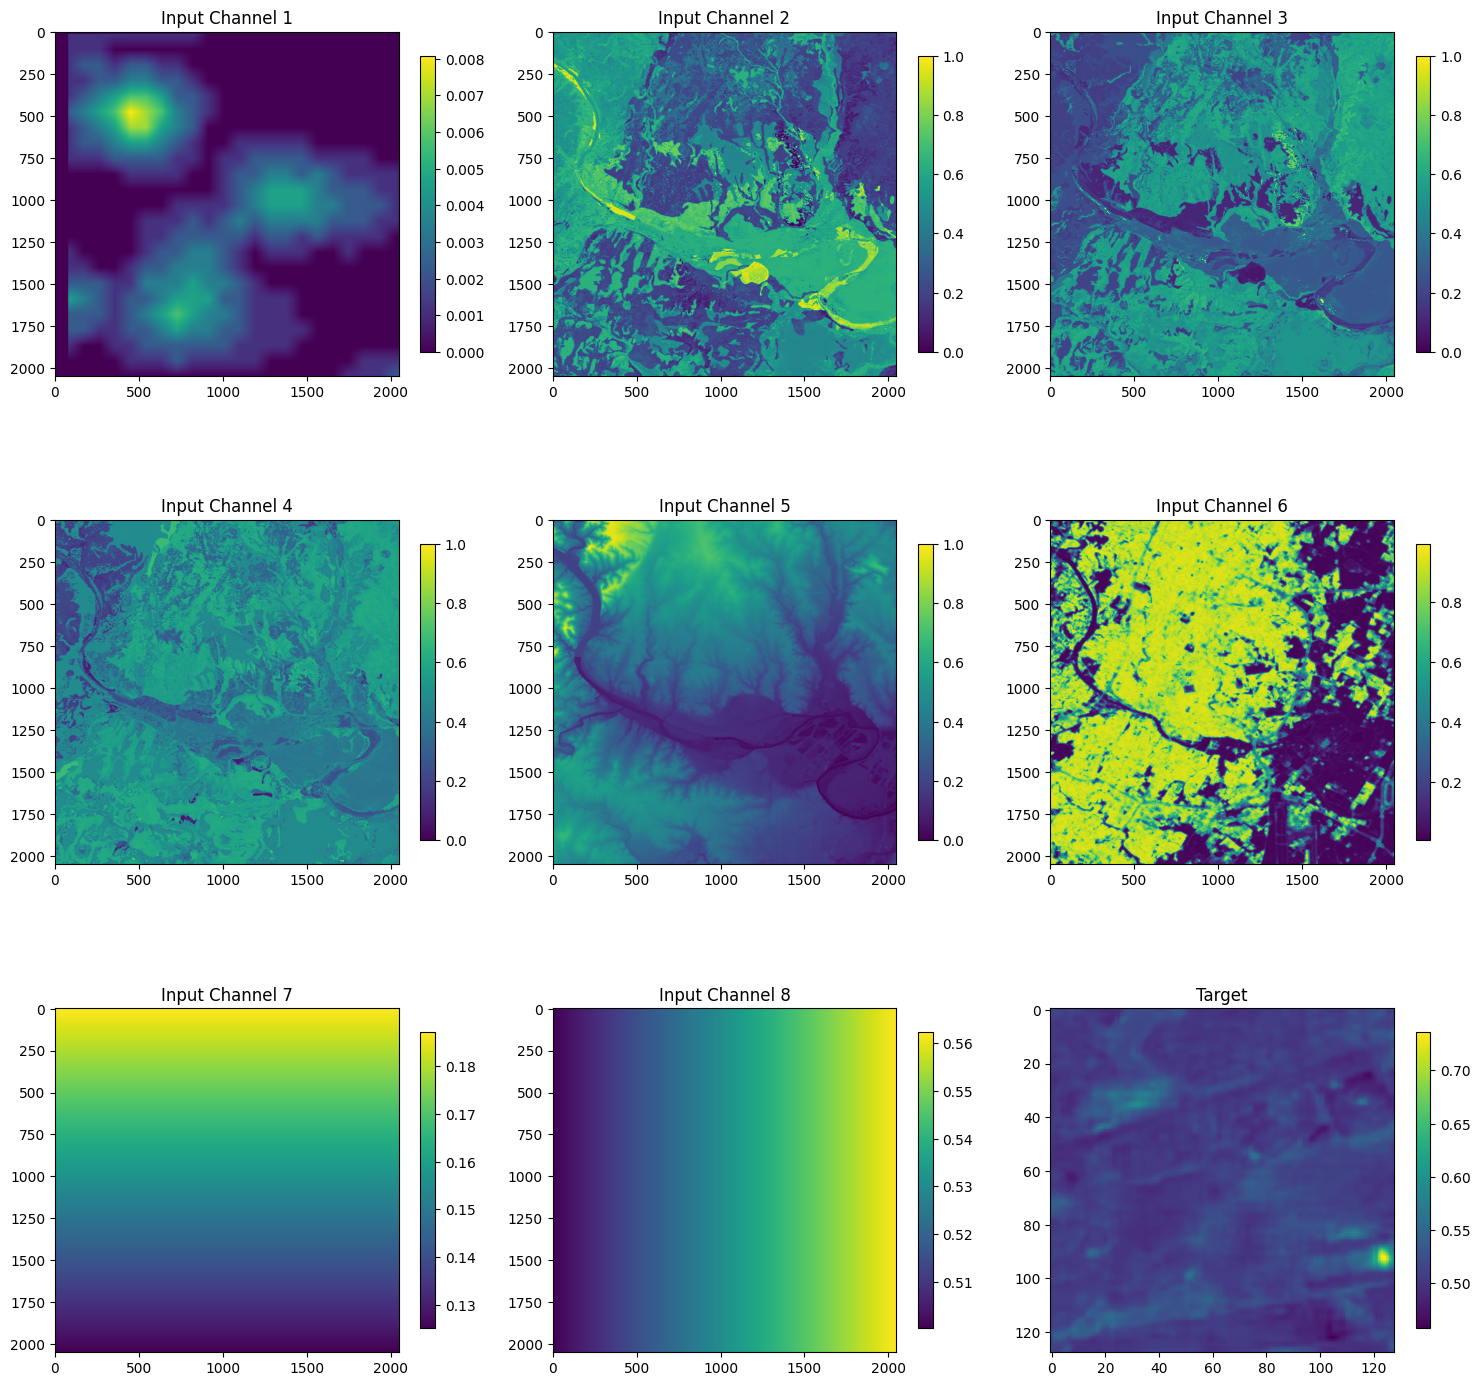

In [77]:
import matplotlib.pyplot as plt

# Get the first data point from the dataset
input, target = dataset.__getitem__(0)

# Number of input channels
num_inputs = input.shape[0]

# Plot all input channels (8 inputs) plus the target
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid to include all 8 inputs + 1 target

for i in range(num_inputs):
    ax = axs[i // 3, i % 3]  # Position in the 3x3 grid
    im = ax.imshow(input[i], cmap='viridis')
    ax.set_title(f'Input Channel {i+1}')
    plt.colorbar(im, ax=ax, shrink=0.6)  # Make the colorbar 80% of its original size

# Plot the target in the last subplot (position 3,3)
ax = axs[-1, -1]  # Bottom-right corner
im = ax.imshow(target.squeeze(), cmap='viridis')
ax.set_title('Target')
plt.colorbar(im, ax=ax, shrink=0.6)  # Make the colorbar 80% of its original size

# Hide any unused subplots if necessary (not needed here since we have exactly 9 subplots)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()